In [2]:
import numpy as np
import pandas as pd
import seaborn as snsg_hexp
from css_utility import *
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import glob

/home/lee/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Check for fine-tuning 

In [24]:
with open("../database/roadmap/gene_exp/css_byCellType/not_exp/E003_not_exp_gene_css.pkl","rb") as f:
    test_not=pickle.load(f)

In [25]:
with open("../database/roadmap/gene_exp/css_byCellType/rpkm0/E003_exp_gene_css.pkl","rb") as f:
    test_0=pickle.load(f)

In [26]:
with open("../database/roadmap/gene_exp/css_byCellType/rpkm10/E003_rpkm10_exp_gene_css.pkl","rb") as f:
    test_10=pickle.load(f)

In [27]:
with open("../database/roadmap/gene_exp/css_byCellType/rpkm20/E003_rpkm20_exp_gene_css.pkl","rb") as f:
    test_20=pickle.load(f)

In [28]:
with open("../database/roadmap/gene_exp/css_byCellType/rpkm30/E003_rpkm30_exp_gene_css.pkl","rb") as f:
    test_30=pickle.load(f)

In [29]:
with open("../database/roadmap/gene_exp/css_byCellType/rpkm50/E003_rpkm50_exp_gene_css.pkl","rb") as f:
    test_50=pickle.load(f)

**sizes and the contents for each case (rpkm) were checked.**

But it seems, in `lee@guitar:/work/lee/DNABERT_tutorial/chromatin_state/database/fine_tune/gene_exp_excl/4mer/all/rpkm0_n_rpkm50`, the labeling is weird and obviously mixed, which implies that the original files used for creating train and dev file might be wrong.

Also, the files merged in `/database/pretrain/gene_exp/4mer` seems okay...

In [42]:
# let's check first

with open("../database/pretrain/gene_exp/4mer/exp_4mer_not_exp_all.txt", "r") as f:
    all_not=[line.strip() for line in f]

In [47]:
all_not[0:50]

['OOOO OOOO OOOO OOOO OOOO OOOE OOEE OEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEED EEDD EDDD DDDD DDDE DDEE DEEE EEEE EEEE',
 'OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOO OOOA OOAA OAAA AAAA AAAA',
 'AAEE AEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEG EEGG EGGG GGGG GGGG GGGE GGEE GEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE 

In [48]:
with open("../database/pretrain/gene_exp/4mer/exp_4mer_rpkm50_excl.txt", "r") as f:
    excl_50=[line.strip() for line in f]

In [49]:
excl_50[0:50]

['AAAA AAAA AAAB AABB ABBG BBGG BGGG GGGG GGGG GGGF GGFF GFFF FFFF FFFF FFFF FFFF FFFF FFFF FFFF FFFG FFGG FGGG GGGG GGGG GGGG GGGG GGGG GGGG GGGG GGGG GGGG GGGE GGED GEDD EDDD DDDD DDDE DDEE DEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEM EEMM EMMM MMML MMLL MLLL LLLL LLLL LLLL LLLL LLLL LLLL LLLG LLGG LGGG GGGA GGAA GAAA AAAA AAAA AAAA AAAA AAAJ AAJK AJKK JKKM KKMM KMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMM MMMJ MMJK MJKK JKKK KKKB KKBG KBGG BGGG GGGG GGGG GGGE GGED GEDD EDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDE DDEE',
 'DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD DDDD

In [50]:
input_path="../database/roadmap/gene_exp/css_byCellType/"
exp_level = sorted(os.listdir(input_path))
paths = {level: os.path.join(input_path, level) for level in exp_level}

In [51]:
exp_level

['not_exp', 'rpkm0', 'rpkm10', 'rpkm20', 'rpkm30', 'rpkm50']

In [64]:
############## UDNER MODIFICATION!!!!!-- used for test

# def prom_FT_save(input_path="../database/pretrain/prom/up2kdown4k/gene_exp/",
#                  output_path="../database/fine_tune/prom/up2kdown4k/gene_exp/",
def test_gene_exp_FT_save(input_path="../database/pretrain/gene_exp/",
                 output_path="../database/fine_tune/test_gene_exp/",
                 cl1="rpkm30",cl2="rpkm50", 
                 len_tr=20000, len_dev=1000,
                 k=4, exclusive=True):
    assert cl1 in ["not", "rpkm0", "rpkm10", "rpkm20", "rpkm30", "rpkm50"], 'use "not", "rpkm0", "rpkm10", "rpkm20", "rpkm30", "rpkm50" for cl1'
    assert cl2 in ["not", "rpkm0", "rpkm10", "rpkm20", "rpkm30", "rpkm50"], 'use "not", "rpkm0", "rpkm10", "rpkm20", "rpkm30", "rpkm50" for cl2'
    
    sub_path=os.path.join(input_path,str(k)+"mer")
    if exclusive:
        tar_cl1=[file for file in os.listdir(sub_path) if cl1 in file and "excl" in file][0]
        cl1_path=os.path.join(sub_path,tar_cl1)
        tar_cl2=[file for file in os.listdir(sub_path) if cl2 in file and "excl" in file][0]
        cl2_path=os.path.join(sub_path,tar_cl2)
    else:
        tar_cl1=[file for file in os.listdir(sub_path) if cl1 in file and "all" in file][0]
        cl1_path=os.path.join(sub_path,tar_cl1)
        tar_cl2=[file for file in os.listdir(sub_path) if cl2 in file and "all" in file][0]
        cl2_path=os.path.join(sub_path,tar_cl2)
    
    with open(cl1_path,"r") as f1:
        cl1_lst=[line.strip() for line in f1]
    with open(cl2_path, "r") as f2:
        cl2_lst=[line.strip() for line in f2]
   
    # make it dataframe
    df_cl1=pd.DataFrame(cl1_lst, columns=["sequence"])
    df_cl1["label"]=0  ###############################################
    df_cl2=pd.DataFrame(cl2_lst, columns=["sequence"])
    df_cl2["label"]=1  ###############################################

    # make them have the same length
    if len(df_cl1)>len(df_cl2):
        df_cl1=df_cl1.sample(n=len(df_cl2), random_state=1) # use the same random state for reproducibility
    elif len(df_cl1)<len(df_cl2):
        df_cl2=df_cl2.sample(n=len(df_cl1), random_state=1) # use the same random state for reproducibility
    assert len(df_cl1)==len(df_cl2), "Check the data length."

    df_all=pd.concat([df_cl1,df_cl2]).sample(frac=1).reset_index(drop=True) 

    # cutting into train and dev
    assert len(df_all)> len_tr+len_dev, "Not enough data length."
    df_train=df_all[:len_tr]
    df_dev=df_all[len_tr:len_tr+len_dev]    

    # save at the fine tuning folder
    data_type=cl1+"_n_"+cl2
    
    if exclusive:
        output_path_fin=os.path.join(output_path,str(k)+"mer","excl",data_type)       
    else:
        output_path_fin=os.path.join(output_path,str(k)+"mer","all",data_type)

    # Check if the directory exists
    if not os.path.exists(output_path_fin):
        # If the directory does not exist, create it
        os.makedirs(output_path_fin)
    
    train_name=os.path.join(output_path_fin,"train.tsv")
    dev_name=os.path.join(output_path_fin,"dev.tsv")

    df_train.to_csv(train_name, sep="\t", index=False)
    df_dev.to_csv(dev_name, sep="\t", index=False)
#     print("Fine tuning files are saved at ", output_path_fin)
    return df_train,df_dev

In [66]:
exp_lst=["not","rpkm0","rpkm10","rpkm20","rpkm30","rpkm50"]
for item in [True,False]:
#     for k in kmers:
#         if k==4:break # for test
    for i in range(len(exp_lst)):
        for j in range(i+1, len(exp_lst)):
            cl1, cl2 = exp_lst[i], exp_lst[j]
            print("saving for the classification: {} and {}".format(cl1, cl2))
            test_gene_exp_FT_save(input_path="../database/pretrain/gene_exp/",
                     output_path="../database/fine_tune/test_gene_exp/",
                     cl1=cl1,cl2=cl2, 
                     len_tr=20000, len_dev=1000,
                     k=4, exclusive=item)

saving for the classification: not and rpkm0
saving for the classification: not and rpkm10
saving for the classification: not and rpkm20
saving for the classification: not and rpkm30
saving for the classification: not and rpkm50
saving for the classification: rpkm0 and rpkm10
saving for the classification: rpkm0 and rpkm20
saving for the classification: rpkm0 and rpkm30
saving for the classification: rpkm0 and rpkm50
saving for the classification: rpkm10 and rpkm20
saving for the classification: rpkm10 and rpkm30
saving for the classification: rpkm10 and rpkm50
saving for the classification: rpkm20 and rpkm30
saving for the classification: rpkm20 and rpkm50
saving for the classification: rpkm30 and rpkm50
saving for the classification: not and rpkm0
saving for the classification: not and rpkm10
saving for the classification: not and rpkm20
saving for the classification: not and rpkm30
saving for the classification: not and rpkm50
saving for the classification: rpkm0 and rpkm10
saving f

In [149]:
path="../database/fine_tune/gene_exp_excl/4mer/excl/"

In [151]:
sub_path=os.listdir(path)

In [164]:
def check_cl1_cl2_compose(path="../database/fine_tune/gene_exp_excl/4mer/excl/"):
    sub_path=os.listdir(path)
    print(len(sub_path))
    
    def ori_seq_maker(kmer_lst):
        seq_ori_lst=[]
        for seq in kmer_lst:
            seq_ori=kmer2seq(seq)
            seq_ori_lst.append(seq_ori)
        return seq_ori_lst
    def create_dict(lst):
        combined_str = ''.join(lst)
        char_count = dict(Counter(combined_str))

        # Filter out characters not in the color_dict and sort by alphabet
        char_count = {k: char_count[k] for k in sorted(state_col_dict_num) if k in char_count}

        labels = char_count.keys()
        sizes = char_count.values()
        colors = [state_col_dict_num[char] for char in labels]

        plt.figure(figsize=(3, 3))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()
        return
    
    for sub in sub_path:
        print(sub)
        train_path=os.path.join(path,sub,"train.tsv")
        train_file=pd.read_csv(train_path, sep="\t")

        low_seq=train_file[train_file["label"]==0]  # labeled as cl1
        high_seq=train_file[train_file["label"]==1] # labeled as cl2

        low_seq_lst=low_seq["sequence"].to_list()
        high_seq_lst=high_seq["sequence"].to_list()   

        low_ori=ori_seq_maker(low_seq_lst)  #original sequence for cl1
        high_ori=ori_seq_maker(high_seq_lst) #original sequence for cl2
        
        print("task:{} | cl1 length:{} | cl2 length:{}".format(sub,len(low_ori),len(high_ori)))

        low_dict=create_dict(low_ori)
        high_dict=create_dict(high_ori)

    return 
    
    

15
not_n_rpkm0
task:not_n_rpkm0 | cl1 length:9873 | cl2 length:10127


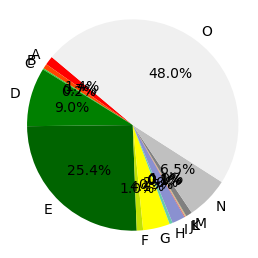

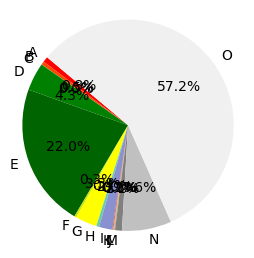

not_n_rpkm10
task:not_n_rpkm10 | cl1 length:10001 | cl2 length:9999


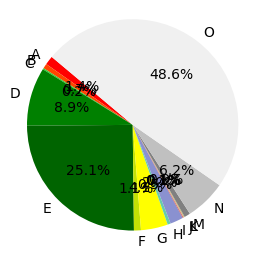

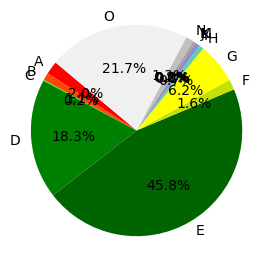

not_n_rpkm20
task:not_n_rpkm20 | cl1 length:9962 | cl2 length:10038


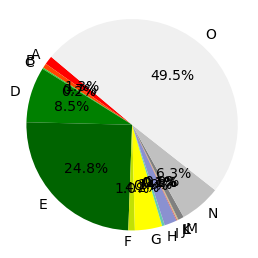

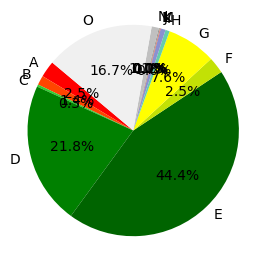

not_n_rpkm30
task:not_n_rpkm30 | cl1 length:9955 | cl2 length:10045


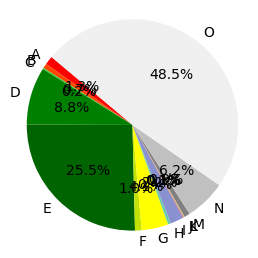

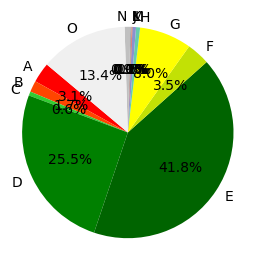

not_n_rpkm50
task:not_n_rpkm50 | cl1 length:9892 | cl2 length:10108


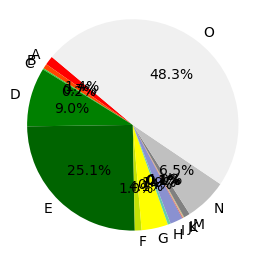

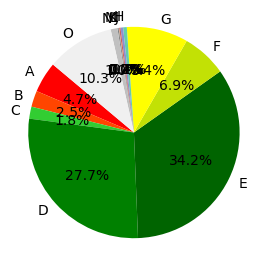

rpkm0_n_rpkm10
task:rpkm0_n_rpkm10 | cl1 length:10037 | cl2 length:9963


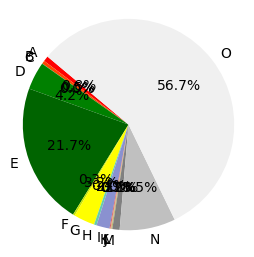

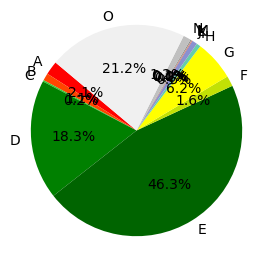

rpkm0_n_rpkm20
task:rpkm0_n_rpkm20 | cl1 length:9957 | cl2 length:10043


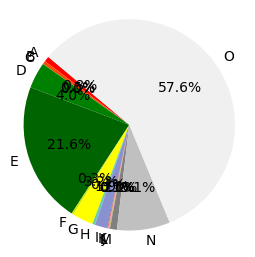

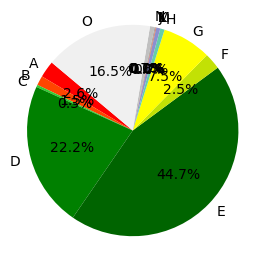

rpkm0_n_rpkm30
task:rpkm0_n_rpkm30 | cl1 length:10098 | cl2 length:9902


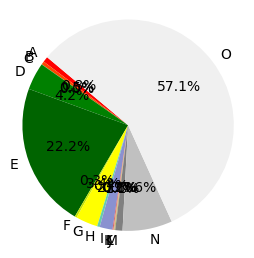

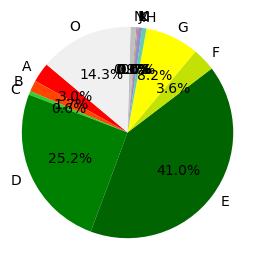

rpkm0_n_rpkm50
task:rpkm0_n_rpkm50 | cl1 length:9976 | cl2 length:10024


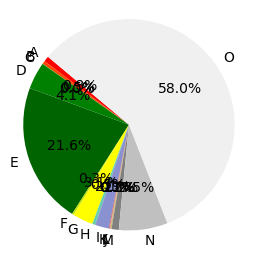

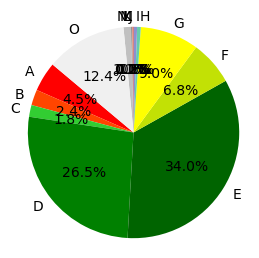

rpkm10_n_rpkm20
task:rpkm10_n_rpkm20 | cl1 length:10069 | cl2 length:9931


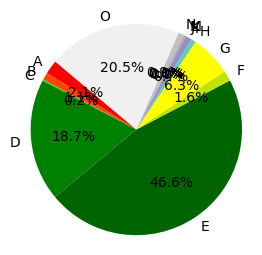

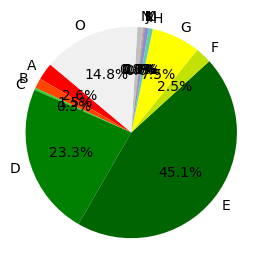

rpkm10_n_rpkm30
task:rpkm10_n_rpkm30 | cl1 length:9991 | cl2 length:10009


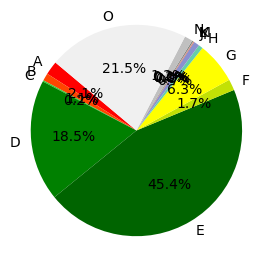

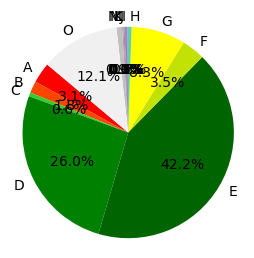

rpkm10_n_rpkm50
task:rpkm10_n_rpkm50 | cl1 length:10046 | cl2 length:9954


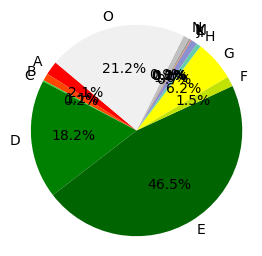

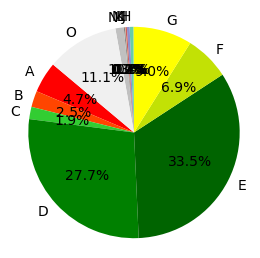

rpkm20_n_rpkm30
task:rpkm20_n_rpkm30 | cl1 length:10028 | cl2 length:9972


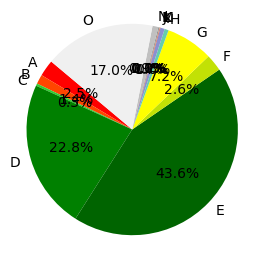

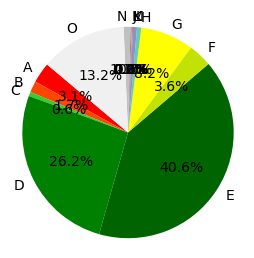

rpkm20_n_rpkm50
task:rpkm20_n_rpkm50 | cl1 length:10052 | cl2 length:9948


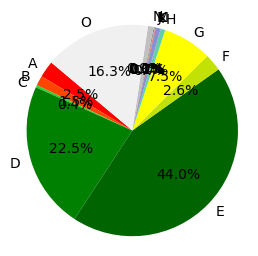

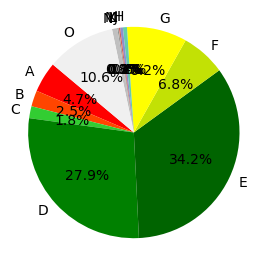

rpkm30_n_rpkm50
task:rpkm30_n_rpkm50 | cl1 length:9870 | cl2 length:10130


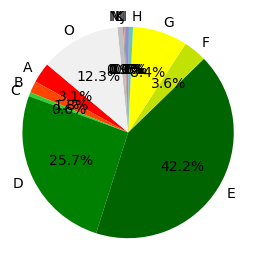

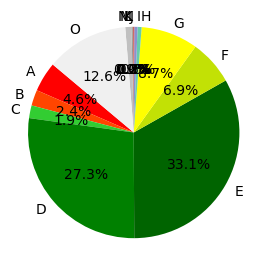

In [165]:
check_cl1_cl2_compose(path="../database/fine_tune/gene_exp_excl/4mer/excl/")

15
not_n_rpkm0
task:not_n_rpkm0 | cl1 length:10021 | cl2 length:9979


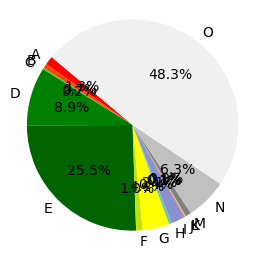

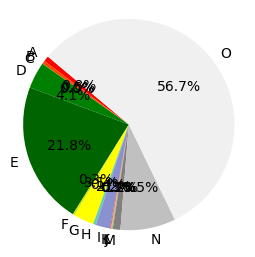

not_n_rpkm10
task:not_n_rpkm10 | cl1 length:10142 | cl2 length:9858


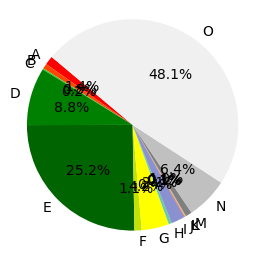

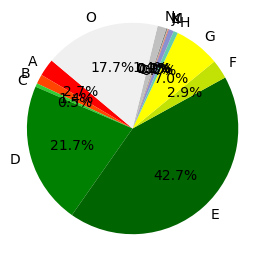

not_n_rpkm20
task:not_n_rpkm20 | cl1 length:9978 | cl2 length:10022


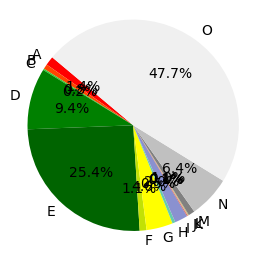

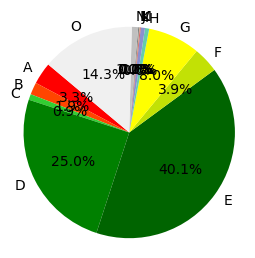

not_n_rpkm30
task:not_n_rpkm30 | cl1 length:10043 | cl2 length:9957


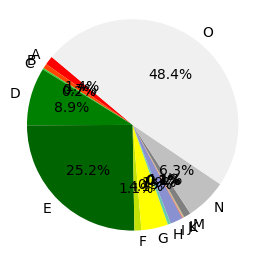

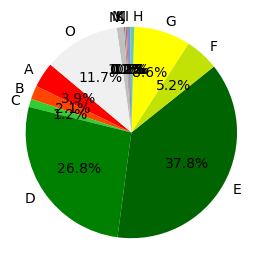

not_n_rpkm50
task:not_n_rpkm50 | cl1 length:9959 | cl2 length:10041


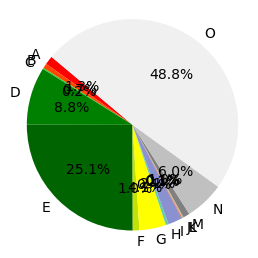

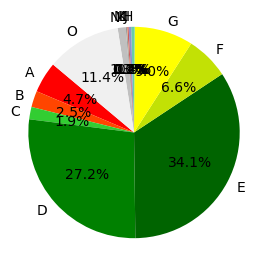

rpkm0_n_rpkm10
task:rpkm0_n_rpkm10 | cl1 length:10093 | cl2 length:9907


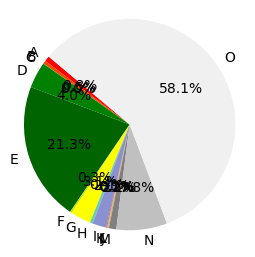

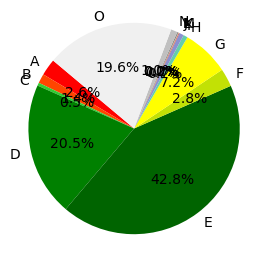

rpkm0_n_rpkm20
task:rpkm0_n_rpkm20 | cl1 length:10085 | cl2 length:9915


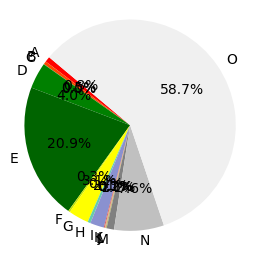

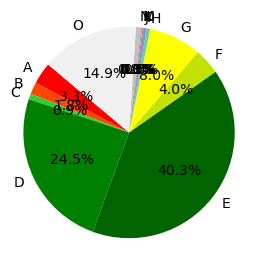

rpkm0_n_rpkm30
task:rpkm0_n_rpkm30 | cl1 length:9968 | cl2 length:10032


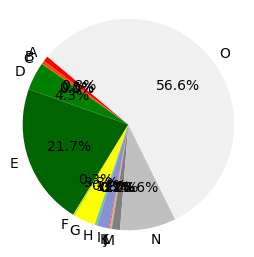

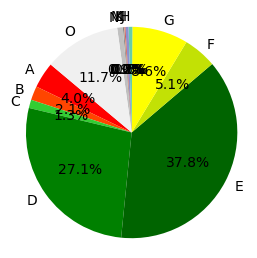

rpkm0_n_rpkm50
task:rpkm0_n_rpkm50 | cl1 length:9854 | cl2 length:10146


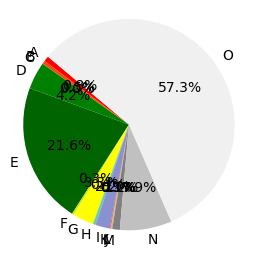

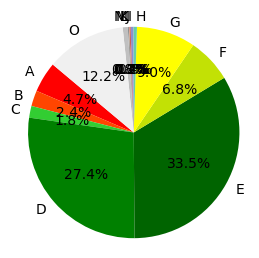

rpkm10_n_rpkm20
task:rpkm10_n_rpkm20 | cl1 length:10006 | cl2 length:9994


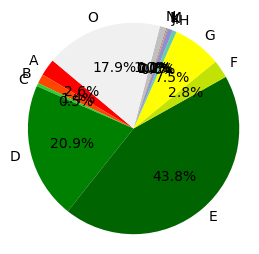

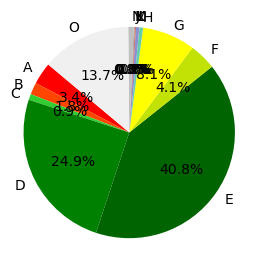

rpkm10_n_rpkm30
task:rpkm10_n_rpkm30 | cl1 length:9962 | cl2 length:10038


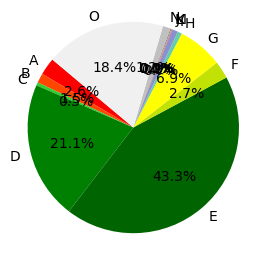

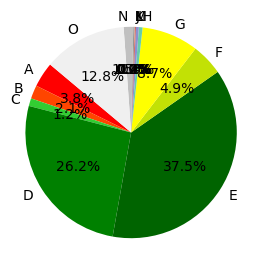

rpkm10_n_rpkm50
task:rpkm10_n_rpkm50 | cl1 length:10067 | cl2 length:9933


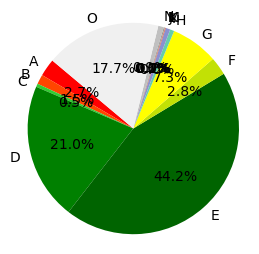

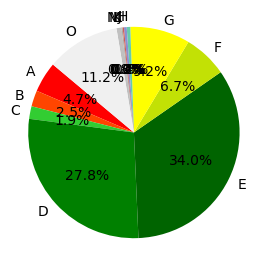

rpkm20_n_rpkm30
task:rpkm20_n_rpkm30 | cl1 length:9939 | cl2 length:10061


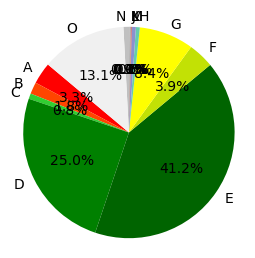

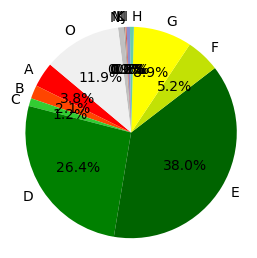

rpkm20_n_rpkm50
task:rpkm20_n_rpkm50 | cl1 length:10010 | cl2 length:9990


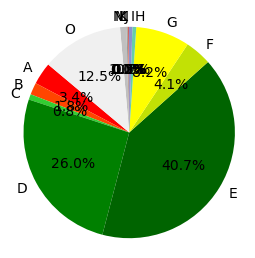

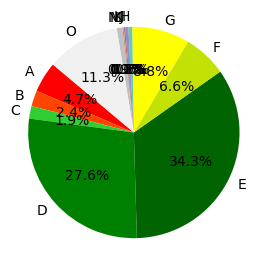

rpkm30_n_rpkm50
task:rpkm30_n_rpkm50 | cl1 length:10002 | cl2 length:9998


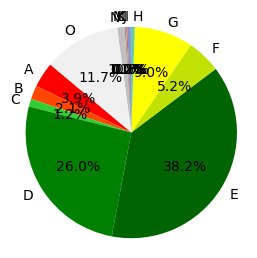

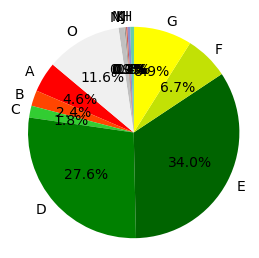

In [166]:
check_cl1_cl2_compose(path="../database/fine_tune/gene_exp_excl/4mer/all/")

### Pretrain for 57 epigenome

files are already at `../database/pretrain/expressed/4mer/whole_gene`

### Fine tuning for gene_exp_expl

Strategy is to extract the strings from `database/roadmap/gene_exp/css_byCellType/` for each case

In [97]:
import os
import pickle

###### remove this and replace it with test_gene_exp_FT_save (prom_FT_save), if the test succeeds

def gene_exp_excl(input_path="../database/roadmap/gene_exp/css_byCellType/", output_path="../database/roadmap/gene_exp/excl/"):
    exp_level = sorted(os.listdir(input_path))
    paths = {level: os.path.join(input_path, level) for level in exp_level}

    data_storage = {}
    exclusive_data = {}

    for tar_level in exp_level:
        tar_path = paths[tar_level]
        file_lst = os.listdir(tar_path)

        tar_level_data = {}

        for file in file_lst:
            file_id = file.split('_')[0]  # Extracting the unique ID (like E003)

            with open(os.path.join(tar_path, file), "rb") as f:
                data = pickle.load(f)
                tar_level_data[file_id] = data

        data_storage[tar_level] = tar_level_data

    tar_levels_to_compare = [
#                              ('not_exp', 'rpkm0'), ('not_exp', 'rpkm10'), ('not_exp', 'rpkm20'), ('not_exp', 'rpkm30'), ('not_exp', 'rpkm50'), 
                             ('rpkm0', 'rpkm10'), ('rpkm0', 'rpkm20'), ('rpkm0', 'rpkm30'), ('rpkm0', 'rpkm50'),
                             ('rpkm10', 'rpkm20'), ('rpkm10', 'rpkm30'), ('rpkm10', 'rpkm50'),
                             ('rpkm20', 'rpkm30'),('rpkm20', 'rpkm50'),('rpkm30', 'rpkm50')]

    def get_filename(file_id, level):
        if level == "not_exp":
            return f"{file_id}_not_exp_gene_css.pkl"
        elif level == "rpkm0":
            return f"{file_id}_exp_gene_css.pkl"
        else:
            return f"{file_id}_{level}_exp_gene_css.pkl"

    for level1, level2 in tar_levels_to_compare:
        exclusive_key = f"{level1}_n_{level2}"
        exclusive_data[exclusive_key] = {}

        for file_id in data_storage[level1]:
            data1 = set(data_storage[level1][file_id])

            file2 = get_filename(file_id, level2)
            
            data2 = set(data_storage[level2][file_id])
            exclusive_list = list(data1.symmetric_difference(data2))
            exclusive_data[exclusive_key][file_id] = exclusive_list

            # Saving the exclusive list data to the output_path
            out_dir = os.path.join(output_path, exclusive_key)
            os.makedirs(out_dir, exist_ok=True)  # Ensures the directory exists, if not creates it
            out_filename = f"{file_id}_{exclusive_key}.pkl"
            with open(os.path.join(out_dir, out_filename), "wb") as out_file:
                pickle.dump(exclusive_list, out_file)

    return exclusive_data

In [98]:
exclusive_data=gene_exp_excl(input_path="../database/roadmap/gene_exp/css_byCellType/", output_path="../database/roadmap/gene_exp/excl/")

In [128]:
prom_css_g_exp_Kmer_by_cell(path="../database/roadmap/gene_exp/css_byCellType/", 
                                output_path="../database/pretrain/gene_exp/",
                                k=4, custom_name="_gene_")

In [136]:
def mergeLst2(path="../database/pretrain/prom/up2kdown4k/gene_exp/",k=4, rpkm=0):
    sub_path=os.path.join(path,str(k)+"mer/")
    if rpkm=="not":
        dir_name="not_exp"
    elif rpkm==0:
        dir_name="rpkm0"
    else:       
        dir_name="rpkm"+str(rpkm)
    tar_path=os.path.join(sub_path, dir_name)
    all_files=[os.path.join(tar_path, file) for file in os.listdir(tar_path)]
    output_name="exp_"+str(k)+"mer_"+dir_name+"_all.txt"
    output_path=os.path.join(sub_path,output_name)
    mergeNcreate(all_files=all_files, output_name=output_path)
    return print("Saved as ", output_path)

In [143]:
mergeLst2(path="../database/pretrain/gene_exp/",k=4, rpkm=20) #repeated for every case

Saved as  ../database/pretrain/gene_exp/4mer/exp_4mer_rpkm20_all.txt


In [145]:
prom_exclusive(input_path="../database/pretrain/gene_exp/4mer",k=4)

../database/pretrain/gene_exp/4mer
['exp_4mer_not_exp_all.txt', 'exp_4mer_rpkm0_all.txt', 'exp_4mer_rpkm10_all.txt', 'exp_4mer_rpkm20_all.txt', 'exp_4mer_rpkm30_all.txt', 'exp_4mer_rpkm50_all.txt']
length of rpkm0:   575581
length of rpkm10:  316885
length of rpkm20:  184656
length of rpkm30:  122609
length of rpkm50:  67955
rpkm0_excl is completed.
rpkm10_excl is completed.
rpkm20_excl is completed.
rpkm30_excl is completed.
All exclusive files are saved at  ../database/pretrain/gene_exp/4mer


In [157]:
# kmers=[3,4,5,6]
exp_lst=["not","rpkm0","rpkm10","rpkm20","rpkm30","rpkm50"]
for item in [True,False]:
#     for k in kmers:
#         if k==4:break # for test
    for i in range(len(exp_lst)):
        for j in range(i+1, len(exp_lst)):
            cl1, cl2 = exp_lst[i], exp_lst[j]           
            prom_FT_save(input_path="../database/pretrain/gene_exp/",
                     output_path="../database/fine_tune/gene_exp_excl/",
                     cl1=cl1,cl2=cl2, 
                     len_tr=20000, len_dev=1000,
                     k=4, exclusive=item)

In [147]:
input_path="../database/pretrain/gene_exp/"

In [ ]:
kmers=[3,4,5,6]
exp_lst=["not","rpkm0","rpkm10","rpkm20","rpkm30","rpkm50"]
for item in [True,False]:
    for k in kmers:
#         if k==4:break # for test
        for i in range(len(exp_lst)):
            for j in range(i+1, len(exp_lst)):
                cl1, cl2 = exp_lst[i], exp_lst[j]           
                prom_FT_save(input_path="../database/pretrain/prom/up2kdown4k/gene_exp/",
                         output_path="../database/fine_tune/prom/up2kdown4k/gene_exp/",
                         cl1=cl1,cl2=cl2, 
                         len_tr=20000, len_dev=1000,
                         k=k, exclusive=item)

In [37]:
exp_lst=["not","rpkm0","rpkm10","rpkm20","rpkm30","rpkm50"]
for i in range(len(exp_lst)):
    for j in range(i+1, len(exp_lst)):
        cl1, cl2 = exp_lst[i], exp_lst[j]   
        print("cl1:{}, cl2:{}".format(cl1,cl2))

cl1:not, cl2:rpkm0
cl1:not, cl2:rpkm10
cl1:not, cl2:rpkm20
cl1:not, cl2:rpkm30
cl1:not, cl2:rpkm50
cl1:rpkm0, cl2:rpkm10
cl1:rpkm0, cl2:rpkm20
cl1:rpkm0, cl2:rpkm30
cl1:rpkm0, cl2:rpkm50
cl1:rpkm10, cl2:rpkm20
cl1:rpkm10, cl2:rpkm30
cl1:rpkm10, cl2:rpkm50
cl1:rpkm20, cl2:rpkm30
cl1:rpkm20, cl2:rpkm50
cl1:rpkm30, cl2:rpkm50


#### Re-generate the Gexp_or_not fine-tuning data, without any NaN value (function modified)

1. For `Gexp_or_not`

In [4]:
input_path="../database/temp_files/expressed/byCellType/"
output_path="../database/fine_tune/gene_exp/4mer/Gexp_or_not/"
cl1="expressed"
cl2="not_expressed"
epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]

In [5]:
prep_and_saveTF_ver01(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'expressed' and 'not_expressed'
* Output path:  ../database/fine_tune/gene_exp/4mer/Gexp_or_not/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 40000 : 1000
Fine-tuning data for expressed and not_expressed (epigenome no. ['E003', 'E006', 'E016', 'E037', 'E050', 'E097', 'E098', 'E112', 'E122', 'E128']) are 4merized and saved at ../database/fine_tune/gene_exp/4mer/Gexp_or_not/tr_len_40k/.


In [7]:
test_df=pd.read_csv("../database/fine_tune/gene_exp/4mer/Gexp_or_not/tr_len_40k/dev.tsv", sep="\t")
test_df["sequence"].isna().sum()

0

2. For `Ghexp_rpkmNN_or_exp`

In [8]:
input_path="../database/temp_files/expressed/byCellType/"
# caution to define the path and cl1, cl2!
output_path="../database/fine_tune/gene_exp/4mer/Ghexp_rpkm10_or_exp/"
cl1="rpkm10_highly_expressed"
cl2="expressed"
epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]

prep_and_saveTF_ver01(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'rpkm10_highly_expressed' and 'expressed'
* Output path:  ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm10_or_exp/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 40000 : 1000
Fine-tuning data for rpkm10_highly_expressed and expressed (epigenome no. ['E003', 'E006', 'E016', 'E037', 'E050', 'E097', 'E098', 'E112', 'E122', 'E128']) are 4merized and saved at ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm10_or_exp/tr_len_40k/.


In [10]:
test_df=pd.read_csv("../database/fine_tune/gene_exp/4mer/Ghexp_rpkm10_or_exp/tr_len_40k/train.tsv", sep="\t")
test_df["sequence"].isna().sum()

0

In [11]:
input_path="../database/temp_files/expressed/byCellType/"
# caution to define the path and cl1, cl2!
output_path="../database/fine_tune/gene_exp/4mer/Ghexp_rpkm20_or_exp/"
cl1="rpkm20_highly_expressed"
cl2="expressed"
epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]

prep_and_saveTF_ver01(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'rpkm20_highly_expressed' and 'expressed'
* Output path:  ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm20_or_exp/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 40000 : 1000
Fine-tuning data for rpkm20_highly_expressed and expressed (epigenome no. ['E003', 'E006', 'E016', 'E037', 'E050', 'E097', 'E098', 'E112', 'E122', 'E128']) are 4merized and saved at ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm20_or_exp/tr_len_40k/.


In [13]:
test_df=pd.read_csv("../database/fine_tune/gene_exp/4mer/Ghexp_rpkm20_or_exp/tr_len_40k/dev.tsv", sep="\t")
test_df["sequence"].isna().sum()

0

In [14]:
input_path="../database/temp_files/expressed/byCellType/"
# caution to define the path and cl1, cl2!
output_path="../database/fine_tune/gene_exp/4mer/Ghexp_rpkm30_or_exp/"
cl1="rpkm30_highly_expressed"
cl2="expressed"
epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]

prep_and_saveTF_ver01(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'rpkm30_highly_expressed' and 'expressed'
* Output path:  ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm30_or_exp/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 40000 : 1000
Fine-tuning data for rpkm30_highly_expressed and expressed (epigenome no. ['E003', 'E006', 'E016', 'E037', 'E050', 'E097', 'E098', 'E112', 'E122', 'E128']) are 4merized and saved at ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm30_or_exp/tr_len_40k/.


In [15]:
test_df=pd.read_csv("../database/fine_tune/gene_exp/4mer/Ghexp_rpkm20_or_exp/tr_len_40k/dev.tsv", sep="\t")
test_df["sequence"].isna().sum()

0

In [56]:
df=pd.read_csv("../database/bed/gene_expression/EG.name.txt", sep="\t", header=None)

In [57]:
len(df)

58

In [58]:
df.drop(index=0, inplace=True)
df

,0,1
1,E003,H1_Cell_Line
2,E004,H1_BMP4_Derived_Mesendoderm_Cultured_Cells
3,E005,H1_BMP4_Derived_Trophoblast_Cultured_Cells
4,E006,H1_Derived_Mesenchymal_Stem_Cells
5,E007,H1_Derived_Neuronal_Progenitor_Cultured_Cells
6,E011,hESC_Derived_CD184+_Endoderm_Cultured_Cells
7,E012,hESC_Derived_CD56+_Ectoderm_Cultured_Cells
8,E013,hESC_Derived_CD56+_Mesoderm_Cultured_Cells
9,E016,HUES64_Cell_Line
10,E024,4star


### In case the length of data is not enough
Use the following scheme: Determine the essential and add the random to make N total

In [59]:
def gene_epi_lst_with_essential(epi_lst, total_num, epi_name_file="../database/bed/gene_expression/EG.name.txt"):
    epi_essential=epi_lst
    total_epi_df=pd.read_csv(epi_name_file, sep="\t", header=None)
    total_epi_df.drop(index=0, inplace=True) # remove the first row which is E000 (not in data)
    total_epi=total_epi_df[0].dropna().to_list()
    remaining_epi=[epi for epi in total_epi if epi not in epi_essential]
    epi_selection=random.sample(remaining_epi, total_num-len(epi_essential))
    epi_to_use=sorted(epi_selection+epi_essential)
    print("Generated list contains following epigenomes: {}".format(epi_to_use))
    return epi_to_use

In [60]:
epi_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]
epi_to_use=gene_epi_lst_with_essential(epi_lst, 20)
# total_epi_df=pd.read_csv("../database/bed/gene_expression/EG.name.txt", sep="\t", header=None)
# total_epi=total_epi_df[0].dropna().to_list()
# remaining_epi=[epi for epi in total_epi if epi not in epi_essential]

# total_selection=20
# epi_selection=random.sample(remaining_epi, total_selection-len(epi_essential))
# epi_to_use=epi_selection+epi_essential

Generated list contains following epigenomes: ['E003', 'E006', 'E007', 'E011', 'E016', 'E037', 'E050', 'E065', 'E066', 'E071', 'E085', 'E087', 'E095', 'E097', 'E098', 'E104', 'E106', 'E112', 'E122', 'E128']


In [61]:
input_path="../database/temp_files/expressed/byCellType/"
# caution to define the path and cl1, cl2!
output_path="../database/fine_tune/gene_exp/4mer/Ghexp_rpkm50_or_exp/"
cl1="rpkm50_highly_expressed"
cl2="expressed"

prep_and_saveTF_ver01(input_path, output_path, cl1, cl2, epi_to_use, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'rpkm50_highly_expressed' and 'expressed'
* Output path:  ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm50_or_exp/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 40000 : 1000
Fine-tuning data for rpkm50_highly_expressed and expressed (epigenome no. ['E003', 'E006', 'E007', 'E011', 'E016', 'E037', 'E050', 'E065', 'E066', 'E071', 'E085', 'E087', 'E095', 'E097', 'E098', 'E104', 'E106', 'E112', 'E122', 'E128']) are 4merized and saved at ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm50_or_exp/tr_len_40k/.


In [66]:
test_df=pd.read_csv("../database/fine_tune/gene_exp/4mer/Ghexp_rpkm50_or_exp/tr_len_40k/dev.tsv", sep="\t")
test_df["sequence"].isna().sum()

0

In [9]:
whole_gene_file

'../database/RefSeq/RefSeq.WholeGene.bed'

In [3]:
g_df_chr_collapsed_lst=Gexp_Gene2GLChr(exp_gene_file='../database/bed/gene_expression/E050/gene_highlyexpressed.refFlat')

Extracting the gene file ...
Done!


In [21]:
def extExpGenic_byCell_1_ver01(output_path="../database/temp_files/expressed/byCellType/refFlat/", all_file=True, high_only=True, verbose=True, exp=0, high_exp=50, **kwargs):
    """
    RUN THE SECOND function 'extExpGenic_byCell_2' after running this function.
    This function extract CSS expressed genic region, mainly for "expressed" and "highly-expressed"
    (1) To process all the  ... set 'all_file=True'.
        If you want to process only one file at a time, set e.g.) all_file=False, file="E050_15_coreMarks_stateno.bed"
    (2) High_only = True will only produce the highly expressed cases (default) 
    (3) Outputs are e.g.) "E112_gene_expressed.refFlat", "E112_gene_highlyexpressed.refFlat" at output path
    """
    
    output_path_mod=output_path+"rpkm"+str(high_exp)+"/"
    
    path="../database/bed/gene_expression/"
    script="classifygenes_ROADMAP_RPKM.py"
    epi_rpkm_tsv="57epigenomes.RPKM.pc.tsv"
    gene_ref="chr.gene.refFlat"
    original_path="~/Work/chromatin_state/NSP/"
    
    save_path="./byCellType/refFlat/"+"rpkm"+str(high_exp)+"/"
    css_bed_path="../database/bed/unzipped/"

    if all_file:
        css_gene_path="../database/temp_files/whole_gene_unit/"
        # File list of CSS on genic region for all cell types
        files_under_folder=sorted(os.listdir(css_gene_path))
        cell_gene_css_all=[file for file in files_under_folder if file.startswith('E') and file.endswith('.pkl')]
        
#         all_css_bed_file=sorted(os.listdir(css_bed_path)) # all css bed file, we need to choose the target
#         # list comprehension to choose the targets (57 epigenomes)    
#         target_cell_gene_css=[css_bed for css_bed in all_css_bed_file for epi in cell_gene_css_all if css_bed[:4]==epi[:4]]
        
        if verbose: print("processing all files ...")
        for epi_css in tqdm_notebook(cell_gene_css_all):             
            epi_num=epi_css[:4] # e.g.) E003
            
            if verbose: print("{} is now processed ...".format(epi_num))
            file_path=css_bed_path+epi_css
#             df=bed2df_expanded(file_path)  # css df

            ######## Running the script at working path and come back to the original path #########
            %cd -q {path}
            %run {script} --thre_expressed {exp} --thre_highlyexpressed {high_exp} {epi_rpkm_tsv} {epi_num} {gene_ref}

            if not high_only:
                exp_file_name=save_path+epi_num+"_"+"gene_expressed.refFlat"
            hexp_file_name=save_path+epi_num+"_"+"gene_highlyexpressed.refFlat"
            %mv "gene_expressed.refFlat" {exp_file_name}
            %mv "gene_highlyexpressed.refFlat" {hexp_file_name}
            %cd -q {original_path}
            ########################################################################################
                
        
    elif len(kwargs)>0:       
        for file_key, file_name in kwargs.items():            
            epi_num=file_name[:4]
            if verbose: print("all_file=False, processing single case for {}.".format(epi_num))

            file_path=css_bed_path+file_name
#             df=bed2df_expanded(file_path)  # css df for the designated file
            
            ######## Running the script at working path and come back to the original path #########
            %cd -q {path}
            %run {script} --thre_expressed {exp} --thre_highlyexpressed {high_exp} {epi_rpkm_tsv} {epi_num} {gene_ref}

            if not high_only:
                exp_file_name=save_path+epi_num+"_"+"gene_expressed.refFlat"
            hexp_file_name=save_path+epi_num+"_"+"gene_highlyexpressed.refFlat"
            %mv "gene_expressed.refFlat" {exp_file_name}
            %mv "gene_highlyexpressed.refFlat" {hexp_file_name}
            %cd -q {original_path}
            ########################################################################################
            
    else:
        raise ValueError("Set all_file=True, or desginate any file name to proceed!")
    assert os.getcwd()[-3:]=="NSP", "Check the current working directory."
    
    return print("Results are stored at {}, and current working directory is : {}".format(output_path_mod, os.getcwd()))
                           

In [24]:
extExpGenic_byCell_1_ver01(output_path="../database/temp_files/expressed/byCellType/refFlat/", all_file=True, high_only=True, verbose=True, exp=0, high_exp=30)

processing all files ...


  0%|          | 0/56 [00:00<?, ?it/s]

E003 is now processed ...
E004 is now processed ...
E005 is now processed ...
E006 is now processed ...
E007 is now processed ...
E011 is now processed ...
E012 is now processed ...
E013 is now processed ...
E016 is now processed ...
E024 is now processed ...
E027 is now processed ...
E028 is now processed ...
E037 is now processed ...
E038 is now processed ...
E047 is now processed ...
E050 is now processed ...
E053 is now processed ...
E054 is now processed ...
E055 is now processed ...
E056 is now processed ...
E057 is now processed ...
E058 is now processed ...
E059 is now processed ...
E061 is now processed ...
E062 is now processed ...
E065 is now processed ...
E066 is now processed ...
E070 is now processed ...
E071 is now processed ...
E079 is now processed ...
E082 is now processed ...
E084 is now processed ...
E085 is now processed ...
E087 is now processed ...
E094 is now processed ...
E095 is now processed ...
E096 is now processed ...
E097 is now processed ...
E098 is now 

In [34]:
def extExpGenic_byCell_2_ver01(output_path="../database/temp_files/expressed/byCellType/",all_file=True, high_only=True, high_exp=50, verbose=True, **kwargs):
    """
    
    """
    exp_ref_path="../database/bed/gene_expression/byCellType/refFlat/"
    hexp_ref_path=exp_ref_path+"rpkm"+str(high_exp)+"/"
    
    ref_exp_file_all=sorted(os.listdir(exp_ref_path))
    ref_hexp_file_all=sorted(os.listdir(hexp_ref_path))
    
    ref_exp_all=[elm for elm in ref_exp_file_all if '_expressed' in elm and elm.startswith('E')]
    ref_hexp_all=[elm for elm in ref_hexp_file_all if 'high' in elm and elm.startswith('E')]
      
    css_gene_path="../database/temp_files/whole_gene_unit/"
    css_bed_path="../database/bed/unzipped/"
    css_bed_file_all=sorted(os.listdir(css_bed_path))    

    if all_file:
        if verbose: print("processing all files ...")
        for epi_css in tqdm_notebook(ref_hexp_all):
            epi_num=epi_css[:4]
            if verbose: print("{} is now processed ...".format(epi_num))
            # preparing df from bed
            target_bed=[elm for elm in css_bed_file_all if elm[:4]==epi_num]
            bed_path=css_bed_path+target_bed[0]
            df=bed2df_expanded(bed_path)
            # preparing ref from exp_refs
            target_hexp_ref=[elm for elm in ref_hexp_all if elm[:4]==epi_num]
            target_exp_ref=[elm for elm in ref_exp_all if elm[:4]==epi_num]
            hexp=hexp_ref_path+target_hexp_ref[0]
            exp=exp_ref_path+target_exp_ref[0]

            if not high_only:  # extract just 'expressed' case if high_only is False (default=True)
                css_exp_gene_lst=comp_expGene2css(exp,df)
                css_exp_gene_unit_lst=flatLst(Convert2unitCSS_main(css_exp_gene_lst, unit=200))
                with open(output_path+"expressed/"+epi_num+"_exp_gene_css.pkl","wb") as g:
                    pickle.dump(css_exp_gene_unit_lst,g)
                    
            css_hexp_gene_lst=comp_expGene2css(hexp,df)
            css_hexp_gene_unit_lst=flatLst(Convert2unitCSS_main(css_hexp_gene_lst, unit=200))
            with open(output_path+"rpkm"+str(high_exp)+"_highly_expressed/"+epi_num+"_highly_exp_gene_css.pkl","wb") as f:
                pickle.dump(css_hexp_gene_unit_lst,f)
            
    elif "file" in kwargs:
        file_name=kwargs["file"]
#         for file_key, file_name in kwargs.items():            
        epi_num=file_name[:4]
        if verbose: print("all_file=False, processing single case for {}.".format(epi_num))
        # preparing df from bed
        target_bed=[elm for elm in css_bed_file_all if elm[:4]==epi_num]
        bed_path=css_bed_path+target_bed[0]
        df=bed2df_expanded(bed_path)
        # preparing ref from exp_refs
        target_hexp_ref=[elm for elm in ref_hexp_all if elm[:4]==epi_num]
        target_exp_ref=[elm for elm in ref_exp_all if elm[:4]==epi_num]
        hexp=hexp_ref_path+target_hexp_ref[0]
        exp=exp_ref_path+target_exp_ref[0]
        
        if not high_only:  # extract just 'expressed' case if high_only is False (default=True)
            css_exp_gene_lst=comp_expGene2css(exp,df)
            css_exp_gene_unit_lst=flatLst(Convert2unitCSS_main(css_exp_gene_lst, unit=200))
            with open(output_path+"expressed/"+epi_num+"_exp_gene_css.pkl","wb") as g:
                pickle.dump(css_exp_gene_unit_lst,g)

        css_hexp_gene_lst=comp_expGene2css(hexp,df)
        css_hexp_gene_unit_lst=flatLst(Convert2unitCSS_main(css_hexp_gene_lst, unit=200))
        with open(output_path+"rpkm"+str(high_exp)+"_highly_expressed/"+epi_num+"_highly_exp_gene_css.pkl","wb") as f:
            pickle.dump(css_hexp_gene_unit_lst,f)

    else:
        raise ValueError("Set all_file=True, or desginate any file name to proceed!")
    return

In [35]:
extExpGenic_byCell_2_ver01(output_path="../database/temp_files/expressed/byCellType/",all_file=False, high_only=True, high_exp=30, verbose=True, file="E003")

all_file=False, processing single case for E003.
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [37]:
extExpGenic_byCell_2_ver01(output_path="../database/temp_files/expressed/byCellType/",all_file=True, high_only=True, high_exp=20, verbose=True)

processing all files ...


  0%|          | 0/56 [00:00<?, ?it/s]

E003 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E004 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E005 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E006 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E007 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E011 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E012 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E013 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E016 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E024 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E027 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E028 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E037 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E038 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E047 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E050 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E053 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E054 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E055 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E056 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E057 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E058 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E059 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E061 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E062 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E065 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E066 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E070 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E071 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E079 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E082 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E084 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E085 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E087 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E094 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E095 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E096 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E097 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E098 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E100 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E104 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E105 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E106 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E109 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E112 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E113 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E114 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E116 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E117 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E118 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E119 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E120 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E122 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E123 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E127 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E128 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!


In [38]:
extExpGenic_byCell_2_ver01(output_path="../database/temp_files/expressed/byCellType/",all_file=True, high_only=True, high_exp=10, verbose=True)

processing all files ...


  0%|          | 0/56 [00:00<?, ?it/s]

E003 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E004 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E005 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E006 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E007 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E011 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E012 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E013 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E016 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E024 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E027 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E028 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E037 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E038 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E047 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E050 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E053 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E054 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E055 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E056 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E057 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E058 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E059 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E061 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E062 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E065 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E066 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E070 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E071 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E079 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E082 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E084 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E085 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E087 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E094 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E095 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E096 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E097 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E098 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E100 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E104 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E105 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E106 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E109 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E112 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E113 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E114 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E116 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E117 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E118 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E119 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E120 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E122 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E123 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E127 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
E128 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!


In [40]:
def save_kmers_ver01(output_path="../database/pretrain/expressed/", high_exp=50, k=4,**kwargs):
    """
    "kind" for kwargs can be chosen among ("whold_gene","not_expressed","expressed", "highly_expressed")
    if "kind" is highly_expressed, RPKM value should be provided as high_exp.
    But this is not very meaningful, because pretrain is conducted with whole_gene only...
    """
    input_path="../database/temp_files/"
    epi_num_lst=pd.read_csv("../database/temp_files/whole_gene_unit/epigenome_lst.txt", header=None, names=["num"])
    epi_num=epi_num_lst["num"].tolist()
    if high_exp:
        print("The threshold for highly expressed is set as RPKM={}".format(high_exp))
    for num in tqdm_notebook(epi_num):   
        if 'kind' in kwargs:
            gene_type=kwargs["kind"]
            if gene_type=="whole_gene":
                file_name=input_path+gene_type+"_unit/"+num+"_css_gene_unit_lst_all.pkl"
            elif gene_type=="not_expressed":
                file_name=input_path+"expressed/byCellType/"+gene_type+"/"+num+"_not_exp_gene_css.pkl"
            elif gene_type=="expressed":
                file_name=input_path+"expressed/byCellType/"+gene_type+"/"+num+"_exp_gene_css.pkl"
            ### note that there is subfolder for highly expressed case
            elif gene_type=="highly_expressed":
                file_name=input_path+"expressed/byCellType/"+"rpkm"+str(high_exp)+"_"+gene_type+"/"+num+"_highly_exp_gene_css.pkl"
            else:
                pass
            with open(file_name, "rb") as f:
                target=pickle.load(f)
                ####### whole_gene is not flat list #######
                if gene_type=="whole_gene":
                    target=flatLst(target)
                ###########################################
                _, kmerized_unit_css=css_CUT_Kmer(target, k=k)
            
        if gene_type=="highly_expressed":
            output_path_mod=output_path+str(k)+"mer/"+"rpkm"+str(high_exp)+"_"+gene_type+"/"+num+"_"+gene_type+".txt"
        else:
            output_path_mod=output_path+str(k)+"mer/"+gene_type+"/"+num+"_"+gene_type+".txt"
        with open(output_path_mod,"w") as g:
            g.write("\n".join(kmerized_unit_css))           
    return 
    

In [41]:
save_kmers_ver01(output_path="../database/pretrain/expressed/", high_exp=30, k=4,kind="highly_expressed")

The threshold for highly expressed is set as RPKM=30


  0%|          | 0/56 [00:00<?, ?it/s]

**Description for `prep_and_saveTF_ver01` function**

Modify the previous function `prep_and_saveTF` to `prep_and_saveTF_ver01`, to deal with the various RPKM cases for Ghexp. Previous function only distinguish cl1 anc cl2, which are respectively given as "expressed", "not_expressed", or "highly expressed", and the internal process of the function consider that there is only one file for each kind in the input path, which is `../database/temp_files/expressed/byCellType/`. However, now there are more than one file for highly_expressed, and the folder names indicate their different condition. 
Therefore, in the new function, `incl_hexp` argument will be added to distinguish whether either cl1 and cl2 is highly_expressed case, and deal with the different name and process for that. 
The output path also should be adjusted according to this kind of change.

In [14]:
# For saving gene expression fine-tuning data
def prep_and_saveTF_ver01(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=20000, len_dev=1000):
    """
    * Generallized function for preparing fine tuning data.
    * Input path will be in the temp_files
    * cl1 and cl2 refer to the name of class you want to classify in binary classification.
    * cl1 and cl2 are any of "expressed", "not_expressed", "rpkmNN_highly_expressed" (NN is number)
    * epi_num_lst should contain the name of epigenomes like "E003." If you need more, then add like ["E003", "E004", ...]
    """
    print("* Input path: ", input_path)
    print("* Binary classification for '{}' and '{}'".format(cl1, cl2))
#     ans= "yes" if incl_hexp else "no"
#     print("* Including highly expressed case: {}".format(ans))
    print("* Output path: ", output_path)
    print("* Cut threshold length: ", cut_thres)
    print("* k-merization: ", k)
    print("* train: dev = {} : {}".format(len_tr,len_dev))
    
    cl1_path=input_path+cl1+"/"
    cl2_path=input_path+cl2+"/"
    
    cl1_concat=[]
    cl2_concat=[]
    
    suffix_dict = {}
    for cl in [cl1, cl2]:
        if "highly" in cl:
#             rpkm_no=re.search(r'rpkm(\d+)',cl).group(1) # no.. this is not required. already inside the name of cl1 an cl2
            suffix_dict[cl] = "_highly_exp_gene_css.pkl"
        elif "not" in cl:
            suffix_dict[cl] = "_not_exp_gene_css.pkl"
        else:
            suffix_dict[cl] = "_exp_gene_css.pkl"
    
    for cl, concat_lst in [(cl1, cl1_concat), (cl2, cl2_concat)]:
        for epi_num in epi_num_lst:
            file_path = input_path + cl + "/" + epi_num + suffix_dict[cl]
            concat_lst.extend(pickle.load(open(file_path, "rb")))
    
    # kmerization
    _, cl1_kmerized=css_CUT_Kmer(cl1_concat, cut_thres, k)
    _, cl2_kmerized=css_CUT_Kmer(cl2_concat, cut_thres, k)
    
    # make it dataframe
    df_cl1=pd.DataFrame(cl1_kmerized, columns=["sequence"])
    df_cl1["label"]=1
    df_cl2=pd.DataFrame(cl2_kmerized, columns=["sequence"])
    df_cl2["label"]=0
    
    # make them have the same length
    if len(df_cl1)>len(df_cl2):
        df_cl1=df_cl1[:len(df_cl2)] 
    elif len(df_cl1)<len(df_cl2):
        df_cl2=df_cl2[:len(df_cl1)]
    assert len(df_cl1)==len(df_cl2), "Check the data length."
    
    # shuffling ...
    df_all=pd.concat([df_cl1,df_cl2]).sample(frac=1).reset_index(drop=True)  

    # cutting into train and dev
    assert len(df_all)> len_tr+len_dev, "Not enough data length."
    df_train=df_all[:len_tr]
    df_dev=df_all[len_tr:len_tr+len_dev]    
  
    #path="../database/fine_tune/"+save_path+"/"+str(k)+"mer/"
    
    by_tr_len=str("{:.0f}".format(len_tr/1000))
    output_path_mod=output_path+"tr_len_"+by_tr_len+"k/"
    
    # create a destination folder if it does not exist.
    if os.path.exists(output_path_mod):
        raise ValueError("Folder already exists:{}".format(output_path_mod))
    else:
        os.makedirs(output_path_mod)
    
    train_name=output_path_mod+"train.tsv"
    dev_name=output_path_mod+"dev.tsv"
    
    df_train.to_csv(train_name, sep="\t", index=False)
    df_dev.to_csv(dev_name, sep="\t", index=False)

    return print("Fine-tuning data for {} and {} (epigenome no. {}) are {}merized and saved at {}.".format(cl1, cl2, epi_num_lst, k, output_path_mod))

In [15]:
# Cut if it is longer than 510
def css_CUT_Kmer(css, cut_thres=510, k=5):
    """ 
    A GENERAL version of `chr_css_CUT_Kmer` and updated to remove any nan in sequence
    Prepare kmer dataset for unit_css, as is if length<=510, else cut it to be length>510   
    Usage: css_CUT_Kmer(css, cut_thres, k)
    
    - css: unit-length css (e.g. comp_gene_css_all)
    - cut_thres: length of split, default=510
    - k: kmer
    
    Output: 1. splitted (before kmerization) 2. kmerized_unit_css (after kmerization) 
    """    
    splitted=[] # bucket for the all the splitted strings   
    for css_elm in css:
        if len(css_elm) <k:  # if the length of css_elm is shorter than k (cannot create k-mer)
            continue
        elif len(css_elm) <=cut_thres:
            splitted.append(css_elm)
        else:  
            prev=0
            while True:
                splitted.append(css_elm[prev:prev+cut_thres])
                prev+=cut_thres
                if prev>=len(css_elm)-1:
                    break      

    kmerized_unit_css_raw=[seq2kmer(item, k) for item in splitted] # k-merize here
    
    ### this part is updated to prevent any empty string to be generated ###
    kmerized_unit_css=[item for item in kmerized_unit_css_raw if item!=""]
    ########################################################################
    
    return splitted, kmerized_unit_css

In [25]:
input_path="../database/temp_files/expressed/byCellType/"
output_path="../database/fine_tune/gene_exp/4mer_test/"
cl1="rpkm30_highly_expressed"
cl2="not_expressed"
epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]

In [27]:
prep_and_saveTF_ver01(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'rpkm30_highly_expressed' and 'not_expressed'
* Output path:  ../database/fine_tune/gene_exp/4mer_test/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 40000 : 1000
Fine-tuning data for rpkm30_highly_expressed and not_expressed (epigenome no. ['E003', 'E006', 'E016', 'E037', 'E050', 'E097', 'E098', 'E112', 'E122', 'E128']) are 4merized and saved at ../database/fine_tune/gene_exp/4mer_test/tr_len_40k/.


In [29]:
test_df=pd.read_csv("../database/fine_tune/gene_exp/4mer_test/tr_len_40k/train.tsv", sep="\t")
test_df["sequence"].isna().sum()
# test_df.head()

0

In [58]:
input_path="../database/temp_files/expressed/byCellType/"
output_path="../database/fine_tune/gene_exp/4mer/Ghexp_rpkm10_or_not/"
cl1="rpkm10_highly_expressed"
cl2="not_expressed"
epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]

In [59]:
prep_and_saveTF_ver01(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'rpkm10_highly_expressed' and 'not_expressed'
* Output path:  ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm10_or_not/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 40000 : 1000
Fine-tuning data for rpkm10_highly_expressed and not_expressed (epigenome no. ['E003', 'E006', 'E016', 'E037', 'E050', 'E097', 'E098', 'E112', 'E122', 'E128']) are 4merized and saved at ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm10_or_not/tr_len_40k/.


In [60]:
input_path="../database/temp_files/expressed/byCellType/"
output_path="../database/fine_tune/gene_exp/4mer/Ghexp_rpkm20_or_not/"
cl1="rpkm20_highly_expressed"
cl2="not_expressed"
epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]
prep_and_saveTF_ver01(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'rpkm20_highly_expressed' and 'not_expressed'
* Output path:  ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm20_or_not/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 40000 : 1000
Fine-tuning data for rpkm20_highly_expressed and not_expressed (epigenome no. ['E003', 'E006', 'E016', 'E037', 'E050', 'E097', 'E098', 'E112', 'E122', 'E128']) are 4merized and saved at ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm20_or_not/tr_len_40k/.


In [61]:
input_path="../database/temp_files/expressed/byCellType/"
output_path="../database/fine_tune/gene_exp/4mer/Ghexp_rpkm30_or_not/"
cl1="rpkm30_highly_expressed"
cl2="not_expressed"
epi_num_lst=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]
prep_and_saveTF_ver01(input_path, output_path, cl1, cl2, epi_num_lst, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

* Input path:  ../database/temp_files/expressed/byCellType/
* Binary classification for 'rpkm30_highly_expressed' and 'not_expressed'
* Output path:  ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm30_or_not/
* Cut threshold length:  510
* k-merization:  4
* train: dev = 40000 : 1000
Fine-tuning data for rpkm30_highly_expressed and not_expressed (epigenome no. ['E003', 'E006', 'E016', 'E037', 'E050', 'E097', 'E098', 'E112', 'E122', 'E128']) are 4merized and saved at ../database/fine_tune/gene_exp/4mer/Ghexp_rpkm30_or_not/tr_len_40k/.


In [39]:
epi_essential=["E003","E006","E016","E037","E050","E097","E098", "E112", "E122", "E128"]
total_epi_df=pd.read_csv("../database/bed/gene_expression/EG.name.txt", sep="\t", header=None)
total_epi=total_epi_df[0].dropna().to_list()
remaining_epi=[epi for epi in total_epi if epi not in epi_essential]

total_selection=20
epi_selection=random.sample(remaining_epi, total_selection-len(epi_essential))
epi_to_use=epi_selection+epi_essential

In [ ]:
input_path="../database/temp_files/expressed/byCellType/"
output_path="../database/fine_tune/gene_exp/4mer/Ghexp_rpkm50_or_not/"
cl1="rpkm50_highly_expressed"
cl2="not_expressed"
prep_and_saveTF_ver01(input_path, output_path, cl1, cl2, epi_to_use, cut_thres=510, k=4, len_tr=40000, len_dev=1000)

In [5]:
type(g_df_chr_collapsed_lst)

list

In [127]:
# genic area for pretrainig test
# test for only one cell, and check the size of the dataset
with open("../database/temp_files/whole_gene_unit/E003_css_gene_unit_lst_all.pkl", "rb") as f:
    test_genic=pickle.load(f)

In [134]:
test_genic=flatLst(test_genic)

In [135]:
splitted_5, kmerized_unit_css_5=css_CUT_Kmer(test_genic,k=5)

**This should be added to the uitility file??**

In [7]:
def save_kmers(output_path="../database/pretrain/",k=4,**kwargs):
    input_path="../database/temp_files/"
    epi_num_lst=pd.read_csv("../database/temp_files/whole_gene_unit/epigenome_lst.txt", header=None, names=["num"])
    epi_num=epi_num_lst["num"].tolist()
    for num in tqdm_notebook(epi_num):   
        if 'kind' in kwargs:
            gene_type=kwargs["kind"]
            if gene_type=="whole_gene":
                file_name=input_path+gene_type+"_unit/"+num+"_css_gene_unit_lst_all.pkl"
            elif gene_type=="not_expressed":
                file_name=input_path+"expressed/byCellType/"+gene_type+"/"+num+"_not_exp_gene_css.pkl"
            elif gene_type=="expressed":
                file_name=input_path+"expressed/byCellType/"+gene_type+"/"+num+"_exp_gene_css.pkl"
            elif gene_type=="highly_expressed":
                file_name=input_path+"expressed/byCellType/"+gene_type+"/"+num+"_highly_exp_gene_css.pkl"
            else:
                pass
            with open(file_name, "rb") as f:
                target=pickle.load(f)
                ####### whole_gene is not flat list #######
                if gene_type=="whole_gene":
                    target=flatLst(target)
                ###########################################
                _, kmerized_unit_css=css_CUT_Kmer(target, k=k)
            output_path_mod=output_path+"expressed/"+str(k)+"mer/"+gene_type+"/"+num+"_"+gene_type+".txt"
            with open(output_path_mod,"w") as g:
                g.write("\n".join(kmerized_unit_css))
           
    return 
    

In [212]:
save_kmers(k=4,kind="whole_gene")

  0%|          | 0/56 [00:00<?, ?it/s]

In [213]:
save_kmers(k=4,kind="highly_expressed")

  0%|          | 0/56 [00:00<?, ?it/s]

In [214]:
save_kmers(k=4,kind="expressed")

  0%|          | 0/56 [00:00<?, ?it/s]

In [215]:
save_kmers(k=4,kind="not_expressed")

  0%|          | 0/56 [00:00<?, ?it/s]

In [216]:
save_kmers(k=5,kind="whole_gene")

  0%|          | 0/56 [00:00<?, ?it/s]

In [217]:
save_kmers(k=5,kind="highly_expressed")

  0%|          | 0/56 [00:00<?, ?it/s]

In [218]:
save_kmers(k=5,kind="expressed")

  0%|          | 0/56 [00:00<?, ?it/s]

In [219]:
save_kmers(k=5,kind="not_expressed")

  0%|          | 0/56 [00:00<?, ?it/s]

In [9]:
save_kmers(k=3,kind="whole_gene")

  0%|          | 0/56 [00:00<?, ?it/s]

In [175]:
epi_num_lst=pd.read_csv("../database/temp_files/whole_gene_unit/epigenome_lst.txt", header=None, names=["num"])

In [140]:
with open("../database/test_E003_5mer.txt","wb") as g:
    pickle.dump(kmerized_unit_css_5,g)

In [9]:
# Now the all genes (as css) are saved, then how to create the training and test dataset

In [32]:
css_hexp_path="../database/temp_files/expressed/byCellType/highly_expressed/"
css_exp_path="../database/temp_files/expressed/byCellType/expressed/"
css_whole="../database/temp_files/whole_gene_unit/"

In [47]:
# total_path=os.listdir(css_whole)
# total_path


In [58]:
whole_gene_files=sorted(glob.glob(css_whole+"*.pkl"))
exp_gene_files=sorted(glob.glob(css_exp_path+"*.pkl"))

# extract whole gene list for different cell types
not_exp_gene_all=[]
for gene_file in whole_gene_files:
    pattern=r'E[0-9]+'
    epi_name=re.findall(pattern, gene_file)[0] # e.g.) 'E003'
    # take expressed gene list for the same cell type
    for file in exp_gene_files:
        if epi_name in file:
            exp_gene_file=file
    with open(gene_file,"rb") as f:
        whole_gene=flatLst(pickle.load(f))
    with open(exp_gene_file, "rb") as g:
        exp_gene=pickle.load(g)
    
    not_exp_gene=[]
    for gene in whole_gene:
        if gene in exp_gene:
            pass
        else:
            not_exp_gene.append(gene)
    not_exp_gene_all.append(not_exp_gene)

len(not_exp_gene_all)
        

56

In [115]:
def extNOTexp_Geneic_byCell(output_path="../database/temp_files/expressed/byCellType/not_expressed/", all_file=True, verbose=True, **kwargs):
  # This function only compares the whole genic with expressed genic and subtract them.
  # Perhaps should be changed later?
    css_exp_path="../database/temp_files/expressed/byCellType/expressed/"
    css_whole="../database/temp_files/whole_gene_unit/"
    whole_gene_files=sorted(glob.glob(css_whole+"*.pkl"))
    exp_gene_files=sorted(glob.glob(css_exp_path+"*.pkl"))

    if all_file: 
        if verbose: print("processing all files ...")
        for gene_file in tqdm_notebook(whole_gene_files):
            pattern=r'E[0-9]+'
            epi_num=re.findall(pattern, gene_file)[0] # e.g.) 'E003'
            # take expressed gene list for the same cell type
            exp_gene_file=[file for file in exp_gene_files if epi_num in file][0]
            with open(gene_file,"rb") as f:
                whole_gene=flatLst(pickle.load(f))
            with open(exp_gene_file, "rb") as g:
                exp_gene=pickle.load(g)
            not_exp_gene_all=[]
            not_exp_gene=[gene for gene in whole_gene if gene not in exp_gene]
            not_exp_gene_all.append(not_exp_gene)
            with open(output_path+epi_num+"_not_exp_gene_css.pkl","wb") as h:
                pickle.dump(not_exp_gene,h)
    
    elif "file" in kwargs:
        exp_gene_file=kwargs["file"]    
        epi_num=exp_gene_file[:4]
        exp_gene_file_w_path=css_exp_path+exp_gene_file
        assert epi_num[0]=="E", "File name should start with 'E'. Remove any path before the file name."
        if verbose: print("all_file=False, processing single case for {}.".format(epi_num))
        
        gene_file=[elm for elm in whole_gene_files if epi_num in elm][0]        
        with open(gene_file,"rb") as f:
            whole_gene=flatLst(pickle.load(f))
        with open(exp_gene_file_w_path, "rb") as g:
            exp_gene=pickle.load(g)
        not_exp_gene=[gene for gene in whole_gene if gene not in exp_gene]
        with open(output_path+epi_num+"_not_exp_gene_css.pkl","wb") as h:
            pickle.dump(not_exp_gene,h)
    else:
        pass
    return print("files are saved at {}".format(output_path))

    

In [116]:
extNOTexp_Geneic_byCell(output_path="../database/temp_files/expressed/byCellType/not_expressed/",file="E003_exp_gene_css.pkl")

processing all files ...


  0%|          | 0/56 [00:00<?, ?it/s]

files are saved at ../database/temp_files/expressed/byCellType/not_expressed/


In [107]:
extNOTexp_Geneic_byCell(output_path="../database/temp_files/expressed/byCellType/not_expressed/",all_file=False,file="E003_exp_gene_css.pkl")

all_file=False, processing single case for E003.
files are saved at ../database/temp_files/expressed/byCellType/not_expressed/


In [121]:
test_path="../database/temp_files/expressed/byCellType/not_expressed/E004_not_exp_gene_css.pkl"
with open (test_path,"rb") as f:
    test=pickle.load(f)
len(test)

19527

In [125]:
test[140]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOONNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAAAAEEEEEEEEEEEEEEEEGGGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNMMMMMMMMNNN'

Total count= 66357


<AxesSubplot:ylabel='Count'>

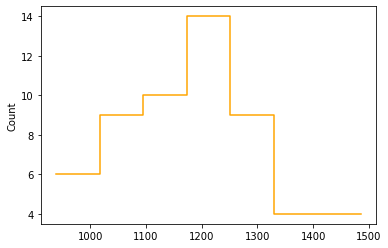

In [34]:
css_hexp_path="../database/temp_files/expressed/byCellType/highly_expressed/"

css_hexp_count_lst=[]
for file in sorted(os.listdir(css_hexp_path)):
    with open(css_hexp_path+file,"rb") as f:
        css_hexp=pickle.load(f)
    css_hexp_count_lst.append(len(css_hexp))
    
print("Total count= {}".format(np.sum(css_hexp_count_lst)))
sns.histplot(css_hexp_count_lst, element="step", fill=False, color="orange")

Total count= 741210


<AxesSubplot:ylabel='Count'>

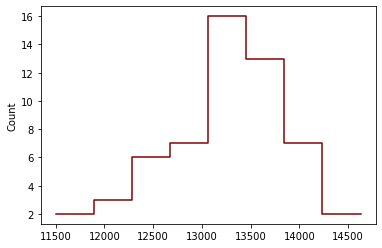

In [36]:
css_exp_path="../database/temp_files/expressed/byCellType/expressed/"

css_exp_count_lst=[]
for file in sorted(os.listdir(css_exp_path)):
    with open(css_exp_path+file,"rb") as f:gi
        css_exp=pickle.load(f)
    css_exp_count_lst.append(len(css_exp))
    
print("Total count= {}".format(np.sum(css_exp_count_lst)))
sns.histplot(css_exp_count_lst, element="step", fill=False, color="maroon")

In [ ]:
with open(css_E122_hexp_path,"rb") as f:
    css_E122_hexp=pickle.load(f)

css_E122_hexp_len=[len(elm) for elm in css_E122_hexp]
sns.histplot(css_E122_hexp_len, log_scale=True, element="step", fill=False, color="orange", bins=15)
print("Total count= {}".format(len(css_E122_hexp_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

### Whole gene extraction

1. Whole gene extraction for a cell (e.g. E112: HUVEC) from ROADMAP data
    * Path: `"../database/bed/unzipped/E112_15_coreMarks_stateno.bed"`
    * Function: `compGene2css(whole_gene_file, df)` where `df` comes from the function `bed2df_expanded`
2. Reduce to the unit length 
    * Input: previous output
    * Function: `Convert2unitCSS_main`

In [418]:
whole_gene_file  # stored at css_utility.py

'../database/RefSeq/RefSeq.WholeGene.bed'

In [417]:
df_e112=bed2df_expanded("../database/bed/unzipped/E112_15_coreMarks_stateno.bed")

In [419]:
css_E112_gene_lst_all=compGene2css(whole_gene_file,df_e112)

Extracting the gene file ...
Done!


In [420]:
css_E112_gene_unit_lst_all=Convert2unitCSS_main(css_E112_gene_lst_all,unit=200)

Converting css from the raw length into unit-length ... 



Done!


Total count= 41923


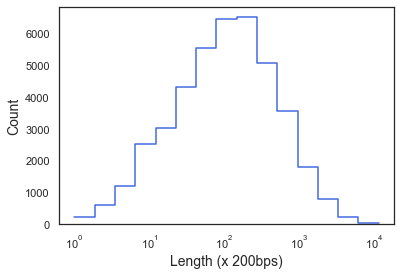

In [422]:
# Visualization: length distibution
css_E112_gene_unit_all=flatLst(css_E112_gene_unit_lst_all)
css_E112_gene_unit_all_len=[len(elm) for elm in css_E112_gene_unit_all]
sns.histplot(css_E112_gene_unit_all_len, log_scale=True, element="step", fill=False, color="royalblue", bins=15)
print("Total count= {}".format(len(css_E112_gene_unit_all_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

In [8]:
css_E112_comp_path="../database/temp_files/complexity/thres_mean/byCellType/E112_comp_gene_css.pkl"
with open(css_E112_comp_path,"rb") as f:
    css_E112_comp=pickle.load(f)
type(css_E112_comp)

list

Total count= 13002


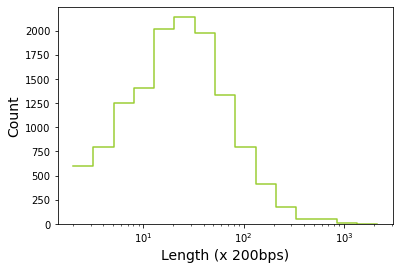

In [13]:
css_E112_comp_len=[len(elm) for elm in css_E112_comp]
sns.histplot(css_E112_comp_len, log_scale=True, element="step", fill=False, color="yellowgreen", bins=15)
print("Total count= {}".format(len(css_E112_comp_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

In [14]:
css_E112_exp_path="../database/temp_files/expressed/byCellType/expressed/E112_exp_gene_css.pkl"
with open(css_E112_exp_path,"rb") as f:
    css_E112_exp=pickle.load(f)
type(css_E112_exp)

list

Total count= 13939


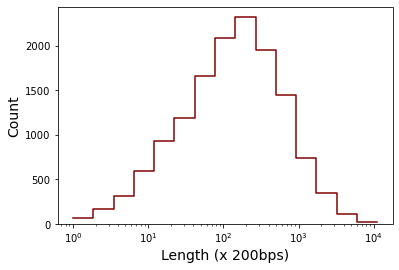

In [17]:
css_E112_exp_len=[len(elm) for elm in css_E112_exp]
sns.histplot(css_E112_exp_len, log_scale=True, element="step", fill=False, color="maroon", bins=15)
print("Total count= {}".format(len(css_E112_exp_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

In [18]:
css_E112_hexp_path="../database/temp_files/expressed/byCellType/highly_expressed/E112_highly_exp_gene_css.pkl"
with open(css_E112_hexp_path,"rb") as f:
    css_E112_hexp=pickle.load(f)
type(css_E112_hexp)

list

Total count= 1202


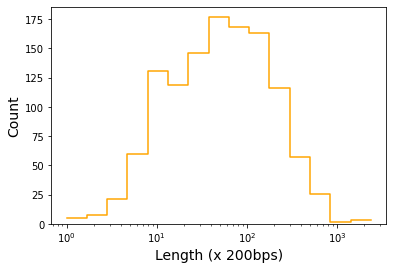

In [19]:
css_E112_hexp_len=[len(elm) for elm in css_E112_hexp]
sns.histplot(css_E112_hexp_len, log_scale=True, element="step", fill=False, color="orange", bins=15)
print("Total count= {}".format(len(css_E112_hexp_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

In [20]:
css_E122_gene_path="../database/temp_files/whole_gene_unit/E122_css_gene_unit_lst_all.pkl"
with open(css_E122_gene_path,"rb") as f:
    css_E122_gene=pickle.load(f)
type(css_E122_gene)

list

Total count= 43385


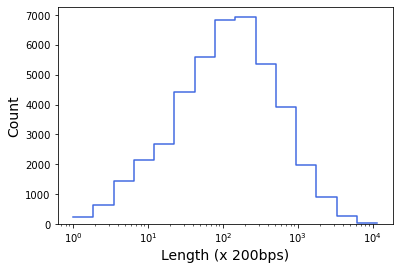

In [22]:
css_E122_gene_len=[len(elm) for elm in flatLst(css_E122_gene)]
sns.histplot(css_E122_gene_len, log_scale=True, element="step", fill=False, color="royalblue", bins=15)
print("Total count= {}".format(len(css_E122_gene_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

Total count= 12966


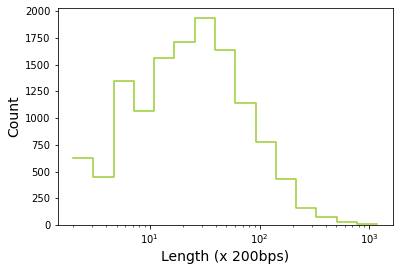

In [23]:
css_E122_comp_path="../database/temp_files/complexity/thres_mean/byCellType/E122_comp_gene_css.pkl"
with open(css_E122_comp_path,"rb") as f:
    css_E122_comp=pickle.load(f)
css_E122_comp_len=[len(elm) for elm in css_E122_comp]
sns.histplot(css_E122_comp_len, log_scale=True, element="step", fill=False, color="yellowgreen", bins=15)
print("Total count= {}".format(len(css_E122_comp_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

Total count= 12460


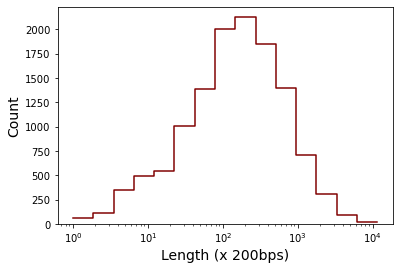

In [25]:
css_E122_exp_path="../database/temp_files/expressed/byCellType/expressed/E122_exp_gene_css.pkl"
with open(css_E122_exp_path,"rb") as f:
    css_E122_exp=pickle.load(f)
css_E122_exp_len=[len(elm) for elm in css_E122_exp]
sns.histplot(css_E122_exp_len, log_scale=True, element="step", fill=False, color="maroon", bins=15)
print("Total count= {}".format(len(css_E122_exp_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

Total count= 1320


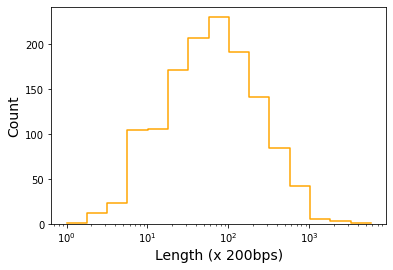

In [26]:
css_E122_hexp_path="../database/temp_files/expressed/byCellType/highly_expressed/E122_highly_exp_gene_css.pkl"
with open(css_E122_hexp_path,"rb") as f:
    css_E122_hexp=pickle.load(f)

css_E122_hexp_len=[len(elm) for elm in css_E122_hexp]
sns.histplot(css_E122_hexp_len, log_scale=True, element="step", fill=False, color="orange", bins=15)
print("Total count= {}".format(len(css_E122_hexp_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

In [442]:
epi_name_path="../database/bed/gene_expression/EG.name.txt"
epi_name_df=pd.read_csv(epi_name_path,sep="\t",header=None,index_col=False)
epi_num=epi_name_df[0].dropna().to_list()

In [448]:
bed_file_path="../database/bed/unzipped/"
bed_file_lst=sorted(os.listdir(bed_file_path))
len(epi_name)

58

In [449]:
len(bed_file_lst)

127

In [450]:
epi_target_tuple=[(num, bed_file) for num in epi_num for bed_file in bed_file_lst if num in bed_file]
epi_target=[tup[1] for tup in epi_target_tuple]
len(epi_target)

56

In [475]:
bed_file_path="../database/bed/unzipped/"
epi_name_path="../database/bed/gene_expression/EG.name.txt"

epi_name_df=pd.read_csv(epi_name_path, names=["epi_num","epi_name"], sep="\t", header=None, index_col=False)
epi_num=epi_name_df["epi_num"].dropna().to_list() # number, 0th field
epi_name=epi_name_df["epi_name"].dropna().to_list() # name, 1st field
bed_file_lst=sorted(os.listdir(bed_file_path))

In [476]:
epi_target_tuple=[(num, bed_file) for num in epi_num for bed_file in bed_file_lst if num in bed_file]
epi_target=[tup[1] for tup in epi_target_tuple]

In [481]:
epi_name_df["epi_name"][epi_name_df["epi_num"]=="E003"][1]

'H1_Cell_Line'

In [544]:
# Save the whole gene area of the 57 epigenomes, in CSS unit sequences
# Following function has been already executed, and pickled at "../database/temp_files/whole_gene_unit/"

def extGenic_byCell(output_path="../database/temp_files/whole_gene_unit/", verbose=True):
    """
    Extract the genic area CSS from the designated 57 epigenome in EG.name.txt
    and save them at "../database/temp_files/whole_gene_unit/"
    """
    # note that EG.name.txt contains E000 (which is not in CSS bed file)
    bed_file_path="../database/bed/unzipped/"
    epi_name_path="../database/bed/gene_expression/EG.name.txt"

    epi_name_df=pd.read_csv(epi_name_path, names=["epi_num","epi_name"], sep="\t", header=None, index_col=False)
    epi_name_df=epi_name_df.dropna()
    epi_num=epi_name_df["epi_num"].dropna().to_list() # number, 0th field
    epi_name=epi_name_df["epi_name"].dropna().to_list() # name, 1st field
    bed_file_lst=sorted(os.listdir(bed_file_path))
    
    # list comprehension for extract the bed files that corresponds to the target epigenome
    epi_target_tuple=[(num, bed_file) for num in epi_num for bed_file in bed_file_lst if num in bed_file]
    epi_target=[tup[1] for tup in epi_target_tuple]
    path="../database/bed/unzipped/"
    
#     print(epi_name_df)
    for epi in epi_target:
        cell_type=epi_name_df.loc[epi_name_df["epi_num"]==epi[:4],"epi_name"].values[0]
        if verbose: 
            print("{}: {} is now processed ...".format(epi, cell_type))
        
        df_epi=bed2df_expanded(path+epi)  # create df of the css for the cell
        css_epi_gene_lst_all=compGene2css(whole_gene_file,df_epi) # list of the css on the genic region
        css_epi_gene_unit_lst_all=Convert2unitCSS_main(css_epi_gene_lst_all,unit=200) # make css to unit length 
        # note that the above list is chromosome-wise list
        
        # total number of genes        
        print("Total number of genes: {}".format(len(flatLst(css_epi_gene_unit_lst_all))))
        
        # pickle it!
        epi_gene_css_name=output_path+epi[:4]+"_css_gene_unit_lst_all.pkl"
        with open(epi_gene_css_name, "wb") as f:
            pickle.dump(css_epi_gene_unit_lst_all,f)

    return print("Files are pickled at {}.".format(output_path))   

In [545]:
extGenic_byCell()

E003_15_coreMarks_stateno.bed: H1_Cell_Line is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43489
E004_15_coreMarks_stateno.bed: H1_BMP4_Derived_Mesendoderm_Cultured_Cells is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 40504
E005_15_coreMarks_stateno.bed: H1_BMP4_Derived_Trophoblast_Cultured_Cells is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 44187
E006_15_coreMarks_stateno.bed: H1_Derived_Mesenchymal_Stem_Cells is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 44213
E007_15_coreMarks_stateno.bed: H1_Derived_Neuronal_Progenitor_Cultured_Cells is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42017
E011_15_coreMarks_stateno.bed: hESC_Derived_CD184+_Endoderm_Cultured_Cells is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43339
E012_15_coreMarks_stateno.bed: hESC_Derived_CD56+_Ectoderm_Cultured_Cells is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42301
E013_15_coreMarks_stateno.bed: hESC_Derived_CD56+_Mesoderm_Cultured_Cells is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43038
E016_15_coreMarks_stateno.bed: HUES64_Cell_Line is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43420
E024_15_coreMarks_stateno.bed: 4star is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43811
E027_15_coreMarks_stateno.bed: Breast_Myoepithelial_Cells is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 44506
E028_15_coreMarks_stateno.bed: Breast_vHMEC is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43695
E037_15_coreMarks_stateno.bed: CD4_Memory_Primary_Cells is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 40031
E038_15_coreMarks_stateno.bed: CD4_Naive_Primary_Cells is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 39685
E047_15_coreMarks_stateno.bed: CD8_Naive_Primary_Cells is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 41213
E050_15_coreMarks_stateno.bed: Mobilized_CD34_Primary_Cells_Female is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43982
E053_15_coreMarks_stateno.bed: Neurosphere_Cultured_Cells_Cortex_Derived is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43496
E054_15_coreMarks_stateno.bed: Neurosphere_Cultured_Cells_Ganglionic_Eminence_Derived is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43086
E055_15_coreMarks_stateno.bed: Penis_Foreskin_Fibroblast_Primary_Cells_skin01 is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 44932
E056_15_coreMarks_stateno.bed: Penis_Foreskin_Fibroblast_Primary_Cells_skin02 is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 44391
E057_15_coreMarks_stateno.bed: Penis_Foreskin_Keratinocyte_Primary_Cells_skin02 is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 44442
E058_15_coreMarks_stateno.bed: Penis_Foreskin_Keratinocyte_Primary_Cells_skin03 is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 44490
E059_15_coreMarks_stateno.bed: Penis_Foreskin_Melanocyte_Primary_Cells_skin01 is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43837
E061_15_coreMarks_stateno.bed: Penis_Foreskin_Melanocyte_Primary_Cells_skin03 is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 44283
E062_15_coreMarks_stateno.bed: Peripheral_Blood_Mononuclear_Primary_Cells is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42627
E065_15_coreMarks_stateno.bed: Aorta is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42795
E066_15_coreMarks_stateno.bed: Adult_Liver is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43708
E070_15_coreMarks_stateno.bed: Brain_Germinal_Matrix is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42696
E071_15_coreMarks_stateno.bed: Brain_Hippocampus_Middle is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43522
E079_15_coreMarks_stateno.bed: Esophagus is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43483
E082_15_coreMarks_stateno.bed: Fetal_Brain_Female is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42817
E084_15_coreMarks_stateno.bed: Fetal_Intestine_Large is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 44100
E085_15_coreMarks_stateno.bed: Fetal_Intestine_Small is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 44228
E087_15_coreMarks_stateno.bed: Pancreatic_Islets is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 41755
E094_15_coreMarks_stateno.bed: Gastric is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42021
E095_15_coreMarks_stateno.bed: Left_Ventricle is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43730
E096_15_coreMarks_stateno.bed: Lung is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 44219
E097_15_coreMarks_stateno.bed: Ovary is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42453
E098_15_coreMarks_stateno.bed: Pancreas is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43592
E100_15_coreMarks_stateno.bed: Psoas_Muscle is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 41977
E104_15_coreMarks_stateno.bed: Right_Atrium is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42767
E105_15_coreMarks_stateno.bed: Right_Ventricle is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42635
E106_15_coreMarks_stateno.bed: Sigmoid_Colon is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42805
E109_15_coreMarks_stateno.bed: Small_Intestine is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 41388
E112_15_coreMarks_stateno.bed: Thymus is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 41923
E113_15_coreMarks_stateno.bed: Spleen is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43149
E114_15_coreMarks_stateno.bed: A549 is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42986
E116_15_coreMarks_stateno.bed: GM12878 is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 41021
E117_15_coreMarks_stateno.bed: HELA is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 40107
E118_15_coreMarks_stateno.bed: HEPG2 is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43802
E119_15_coreMarks_stateno.bed: HMEC is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43554
E120_15_coreMarks_stateno.bed: HSMM is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42866
E122_15_coreMarks_stateno.bed: HUVEC is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 43385
E123_15_coreMarks_stateno.bed: K562 is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 39981
E127_15_coreMarks_stateno.bed: NHEK is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42670
E128_15_coreMarks_stateno.bed: NHLF is now processed ...
Extracting the gene file ...
Done!



Converting css from the raw length into unit-length ... 



Done!
Total number of genes: 42562
Files are pickled at ../database/temp_files/whole_gene_unit/.


### Complex gene extraction

1. Based on the CSS extracted for genic region, use `extract_complex_css(gene_css_all, thres="mean")` to build the function for all the epigenome.
2. Whole gene CSS for each epigenomes are saved at `../database/temp_files/whole_gene_unit`

In [579]:
# Save the complex and less complex genic area of the 57 epigenomes, in CSS unit sequences
# Following function has been already executed, and pickled at "../database/temp_files/complexity/thres_mean/byCellType/"

def extCompGenic_byCell(output_path="../database/temp_files/complexity/", thres="mean", all_file=True, verbose=True, **kwargs):
    """
    This function extract CSS complex and less-complex genic region, according to the threshold.
    (1) To process all the .pkl file in ../database/temp_files/whole_gene_unit/, set 'all_file=True'.
        If you want to process only one file at a time, set e.g.) all_file=False, file=E003_css_gene_unit_lst_all.pkl
    """
    
    css_gene_path="../database/temp_files/whole_gene_unit/"
    if thres=="mean":
        output_path_mod=output_path+"thres_"+thres+"/byCellType/"
    else:
        print("No threshold other than 'mean'.")
    
    # File list of CSS on genic region for all cell types
    files_under_folder=sorted(os.listdir(css_gene_path))
    cell_gene_css_all=[file for file in files_under_folder if file.startswith('E') and file.endswith('.pkl')]
    
    if all_file:
        if verbose: print("processing all files ...")
        for epi_css in tqdm_notebook(cell_gene_css_all):             
            epi_num=epi_css[:4] # e.g.) E003
            if verbose: print("{} is now processed ...".format(epi_num))
            file_path=css_gene_path+epi_css
            with open(file_path,"rb") as f:
                cell_gene_css=pickle.load(f)
            comp_gene_css,less_comp_gene_css=extract_complex_css(cell_gene_css, thres=thres)
            comp_name=output_path_mod+epi_num+"_comp_gene_css.pkl"
            less_name=output_path_mod+epi_num+"_less_comp_gene_css.pkl"
            with open(comp_name,"wb") as g:
                pickle.dump(comp_gene_css, g)
            with open(less_name,"wb") as h:
                pickle.dump(less_comp_gene_css, h)  
                           
    elif len(kwargs)>0:
        for file_key, file_name in kwargs.items():            
            epi_num=file_name[:4]
            file_path=css_gene_path+file_name
            if verbose: print("all_file=False, processing single case for {}.".format(epi_num))
            with open(file_path,"rb") as f:
                cell_gene_css=pickle.load(f)
            comp_gene_css,less_comp_gene_css=extract_complex_css(cell_gene_css, thres=thres)
            comp_name=output_path_mod+epi_num+"_comp_gene_css.pkl"
            less_name=output_path_mod+epi_num+"_less_comp_gene_css.pkl"
            with open(comp_name,"wb") as g:
                pickle.dump(comp_gene_css, g)
            with open(less_name,"wb") as h:
                pickle.dump(less_comp_gene_css, h)               
    else:
        raise ValueError("Set all_file=True, or desginate any file name to proceed!")
    
    return print("Results are stored at {}".format(output_path_mod))

# extract_complex_css(gene_css_all, thres="mean")

In [578]:
extCompGenic_byCell()

processing all files ...


E003 is now processed ...
E004 is now processed ...
E005 is now processed ...
E006 is now processed ...
E007 is now processed ...
E011 is now processed ...
E012 is now processed ...
E013 is now processed ...
E016 is now processed ...
E024 is now processed ...
E027 is now processed ...
E028 is now processed ...
E037 is now processed ...
E038 is now processed ...
E047 is now processed ...
E050 is now processed ...
E053 is now processed ...
E054 is now processed ...
E055 is now processed ...
E056 is now processed ...
E057 is now processed ...
E058 is now processed ...
E059 is now processed ...
E061 is now processed ...
E062 is now processed ...
E065 is now processed ...
E066 is now processed ...
E070 is now processed ...
E071 is now processed ...
E079 is now processed ...
E082 is now processed ...
E084 is now processed ...
E085 is now processed ...
E087 is now processed ...
E094 is now processed ...
E095 is now processed ...
E096 is now processed ...
E097 is now processed ...
E098 is now 

In [658]:
def extExpGenic_byCell_1(output_path="../database/temp_files/expressed/byCellType/refFlat/", all_file=True, verbose=True, exp=0, high_exp=50, **kwargs):
    """
    RUN THE SECOND function 'extExpGenic_byCell_2' after running this function.
    This function extract CSS expressed genic region, mainly for "expressed" and "highly-expressed"
    (1) To process all the  ... set 'all_file=True'.
        If you want to process only one file at a time, set e.g.) all_file=False, file="E050_15_coreMarks_stateno.bed"
    (2) Current version is only for expressed/ highly expressed cases.
    (3) Outputs are e.g.) "E112_gene_expressed.refFlat", "E112_gene_highlyexpressed.refFlat" at output path
    """
    
    path="../database/bed/gene_expression/"
    script="classifygenes_ROADMAP_RPKM.py"
    epi_rpkm_tsv="57epigenomes.RPKM.pc.tsv"
    gene_ref="chr.gene.refFlat"
    original_path="~/Work/chromatin_state/NSP/"
    
    save_path="./byCellType/refFlat/"
#     css_bed_path="../database/bed/unzipped/"

    if all_file:
        css_gene_path="../database/temp_files/whole_gene_unit/"
        # File list of CSS on genic region for all cell types
        files_under_folder=sorted(os.listdir(css_gene_path))
        cell_gene_css_all=[file for file in files_under_folder if file.startswith('E') and file.endswith('.pkl')]
        
#         all_css_bed_file=sorted(os.listdir(css_bed_path)) # all css bed file, we need to choose the target
#         # list comprehension to choose the targets (57 epigenomes)    
#         target_cell_gene_css=[css_bed for css_bed in all_css_bed_file for epi in cell_gene_css_all if css_bed[:4]==epi[:4]]
        
        if verbose: print("processing all files ...")
        for epi_css in tqdm_notebook(cell_gene_css_all):             
            epi_num=epi_css[:4] # e.g.) E003
            
            if verbose: print("{} is now processed ...".format(epi_num))
            file_path=css_bed_path+epi_css
#             df=bed2df_expanded(file_path)  # css df

            ######## Running the script at working path and come back to the original path #########
            %cd -q {path}
            %run {script} --thre_expressed {exp} --thre_highlyexpressed {high_exp} {epi_rpkm_tsv} {epi_num} {gene_ref}

            exp_file_name=save_path+epi_num+"_"+"gene_expressed.refFlat"
            hexp_file_name=save_path+epi_num+"_"+"gene_highlyexpressed.refFlat"
            %mv "gene_expressed.refFlat" {exp_file_name}
            %mv "gene_highlyexpressed.refFlat" {hexp_file_name}
            %cd -q {original_path}
            ########################################################################################
                
        
    elif len(kwargs)>0:       
        for file_key, file_name in kwargs.items():            
            epi_num=file_name[:4]
            if verbose: print("all_file=False, processing single case for {}.".format(epi_num))

            file_path=css_bed_path+file_name
#             df=bed2df_expanded(file_path)  # css df for the designated file
            
            ######## Running the script at working path and come back to the original path #########
            %cd -q {path}
            %run {script} --thre_expressed {exp} --thre_highlyexpressed {high_exp} {epi_rpkm_tsv} {epi_num} {gene_ref}

            exp_file_name=save_path+epi_num+"_"+"gene_expressed.refFlat"
            hexp_file_name=save_path+epi_num+"_"+"gene_highlyexpressed.refFlat"
            %mv "gene_expressed.refFlat" {exp_file_name}
            %mv "gene_highlyexpressed.refFlat" {hexp_file_name}
            %cd -q {original_path}
            ########################################################################################
            
    else:
        raise ValueError("Set all_file=True, or desginate any file name to proceed!")
    assert os.getcwd()[-3:]=="NSP", "Check the current working directory."
    
    return print("Results are stored at {}, and current working directory is : {}".format(output_path, os.getcwd()))
                           

In [657]:
#test
extExpGenic_byCell_1(all_file=False,file="E122_15_coreMarks_stateno.bed")

all_file=False, processing single case for E122.
Results are stored at ../database/temp_files/expressed/byCellType/refFlat/, and current working directory is : /Users/schona/Work/chromatin_state/NSP


In [659]:
#main
extExpGenic_byCell_1()

processing all files ...


E003 is now processed ...
E004 is now processed ...
E005 is now processed ...
E006 is now processed ...
E007 is now processed ...
E011 is now processed ...
E012 is now processed ...
E013 is now processed ...
E016 is now processed ...
E024 is now processed ...
E027 is now processed ...
E028 is now processed ...
E037 is now processed ...
E038 is now processed ...
E047 is now processed ...
E050 is now processed ...
E053 is now processed ...
E054 is now processed ...
E055 is now processed ...
E056 is now processed ...
E057 is now processed ...
E058 is now processed ...
E059 is now processed ...
E061 is now processed ...
E062 is now processed ...
E065 is now processed ...
E066 is now processed ...
E070 is now processed ...
E071 is now processed ...
E079 is now processed ...
E082 is now processed ...
E084 is now processed ...
E085 is now processed ...
E087 is now processed ...
E094 is now processed ...
E095 is now processed ...
E096 is now processed ...
E097 is now processed ...
E098 is now 

In [ ]:
css_gene_lst_all=comp_expGene2css("../database/bed/gene_expression/gene_highlyexpressed.refFlat",df_e050)
css_unit_lst_all=Convert2unitCSS_main(css_gene_lst_all, unit=200)
g_hexp_css_all=flatLst(css_unit_lst_all)

In [5]:
def extExpGenic_byCell_2(output_path="../database/temp_files/expressed/byCellType/",all_file=True, verbose=True, **kwargs):
    """
    
    """
    ref_path="../database/bed/gene_expression/byCellType/refFlat/"
    ref_file_all=sorted(os.listdir(ref_path))
    ref_hexp_all=[elm for elm in ref_file_all if 'high' in elm and elm.startswith('E')]
    ref_exp_all=[elm for elm in ref_file_all if elm not in ref_hexp_all and elm.startswith('E')]
    
    css_gene_path="../database/temp_files/whole_gene_unit/"
    css_bed_path="../database/bed/unzipped/"
    css_bed_file_all=sorted(os.listdir(css_bed_path))    

    if all_file:
        if verbose: print("processing all files ...")
        for epi_css in tqdm_notebook(ref_hexp_all):
            epi_num=epi_css[:4]
            if verbose: print("{} is now processed ...".format(epi_num))
            # preparing df from bed
            target_bed=[elm for elm in css_bed_file_all if elm[:4]==epi_num]
            bed_path=css_bed_path+target_bed[0]
            df=bed2df_expanded(bed_path)
            # preparing ref from exp_refs
            target_hexp_ref=[elm for elm in ref_hexp_all if elm[:4]==epi_num]
            target_exp_ref=[elm for elm in ref_exp_all if elm[:4]==epi_num]
            hexp=ref_path+target_hexp_ref[0]
            exp=ref_path+target_exp_ref[0]
            
            css_hexp_gene_lst=comp_expGene2css(hexp,df)
            css_exp_gene_lst=comp_expGene2css(exp,df)
            css_hexp_gene_unit_lst=flatLst(Convert2unitCSS_main(css_hexp_gene_lst, unit=200))
            css_exp_gene_unit_lst=flatLst(Convert2unitCSS_main(css_exp_gene_lst, unit=200))

            with open(output_path+"highly_expressed/"+epi_num+"_highly_exp_gene_css.pkl","wb") as f:
                pickle.dump(css_hexp_gene_unit_lst,f)
            with open(output_path+"expressed/"+epi_num+"_exp_gene_css.pkl","wb") as g:
                pickle.dump(css_exp_gene_unit_lst,g)
            
#     elif len(kwargs)>0:
    elif "file" in kwargs:
        file_name=kwargs["file"]
#         for file_key, file_name in kwargs.items():            
        epi_num=file_name[:4]
        if verbose: print("all_file=False, processing single case for {}.".format(epi_num))
        # preparing df from bed
        target_bed=[elm for elm in css_bed_file_all if elm[:4]==epi_num]
        bed_path=css_bed_path+target_bed[0]
        df=bed2df_expanded(bed_path)
        # preparing ref from exp_refs
        target_hexp_ref=[elm for elm in ref_hexp_all if elm[:4]==epi_num]
        target_exp_ref=[elm for elm in ref_exp_all if elm[:4]==epi_num]
        hexp=ref_path+target_hexp_ref[0]
        exp=ref_path+target_exp_ref[0]

        css_hexp_gene_lst=comp_expGene2css(hexp,df)
        css_exp_gene_lst=comp_expGene2css(exp,df)
        css_hexp_gene_unit_lst=flatLst(Convert2unitCSS_main(css_hexp_gene_lst, unit=200))
        css_exp_gene_unit_lst=flatLst(Convert2unitCSS_main(css_exp_gene_lst, unit=200))

        with open(output_path+"highly_expressed/"+epi_num+"_highly_exp_gene_css.pkl","wb") as f:
            pickle.dump(css_hexp_gene_unit_lst,f)
        with open(output_path+"expressed/"+epi_num+"_exp_gene_css.pkl","wb") as g:
            pickle.dump(css_exp_gene_unit_lst,g)

    else:
        raise ValueError("Set all_file=True, or desginate any file name to proceed!")
    return

In [6]:
extExpGenic_byCell_2(all_file=False,file="E122")

all_file=False, processing single case for E122.
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [7]:
extExpGenic_byCell_2()

processing all files ...


  0%|          | 0/56 [00:00<?, ?it/s]

E003 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E004 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E005 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E006 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E007 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E011 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E012 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E013 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E016 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E024 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E027 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E028 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E037 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E038 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E047 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E050 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E053 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E054 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E055 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E056 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E057 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E058 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E059 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E061 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E062 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E065 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E066 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E070 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E071 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E079 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E082 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E084 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E085 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E087 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E094 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E095 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E096 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E097 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E098 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E100 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E104 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E105 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E106 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E109 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E112 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E113 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E114 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E116 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E117 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E118 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E119 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E120 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E122 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E123 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E127 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E128 is now processed ...
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/23 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [660]:
ref_path="../database/bed/gene_expression/byCellType/refFlat/"
ref_file_all=sorted(os.listdir(ref_path))

In [665]:
ref_hexp_all=[elm for elm in ref_file_all if 'high' in elm and elm.startswith('E')]
ref_exp_all=[elm for elm in ref_file_all if elm not in ref_hexp_all and elm.startswith('E')]

In [629]:
print(os.getcwd()[-3:]=="NSP")

True


In [668]:
css_bed_path="../database/bed/unzipped/"
css_bed_file_all=sorted(os.listdir(css_bed_path))

target_bed=[elm for elm in css_bed_file_all if elm[:4]==epi_num]

In [670]:
for epi_css in ref_hexp_all:
    epi_num=epi_css[:4]
    print(epi_num)
    target_bed=[elm for elm in css_bed_file_all if elm[:4]==epi_num]
    break

E003


In [673]:
target_bed[0]

'E003_15_coreMarks_stateno.bed'

In [397]:
### First, whole gene for E050
# df_e050=bed2df_expanded("../database/bed/unzipped/E050_15_coreMarks_stateno.bed")
css_E050_gene_lst_all=compGene2css(whole_gene_file,df_e050)

Extracting the gene file ...
Done!


In [398]:
css_E050_gene_unit_lst_all=Convert2unitCSS_main(css_E050_gene_lst_all, unit=200)

Converting css from the raw length into unit-length ... 



Done!


In [403]:
g_e050_css_all_len=[len(elm) for elm in flatLst(css_E050_gene_unit_lst_all)]

Total count= 43982


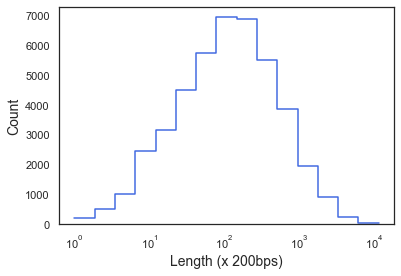

In [404]:
sns.histplot(g_e050_css_all_len,log_scale=True, element="step", fill=False, color="royalblue", bins=15)
print("Total count= {}".format(len(g_e050_css_all_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

In [ ]:
## next, complex gene for e050

In [405]:
e050_comp_gene_css_all,e050_less_comp_gene_css_all=extract_complex_css(css_E050_gene_unit_lst_all, thres="mean")

In [411]:
path_comp_e050="../database/temp_files/complexity/thres_mean/byCellType/E050/comp.pkl"

In [412]:
with open(path_comp_e050, "wb") as f:
    pickle.dump(e050_comp_gene_css_all,f)

In [413]:
path_less_e050="../database/temp_files/complexity/thres_mean/byCellType/E050/less_comp.pkl"

In [414]:
with open(path_less_e050, "wb") as g:
    pickle.dump(e050_less_comp_gene_css_all,g)

In [415]:
e050_comp_gene_css_all_len=[len(elm) for elm in e050_comp_gene_css_all]

Total count= 13298


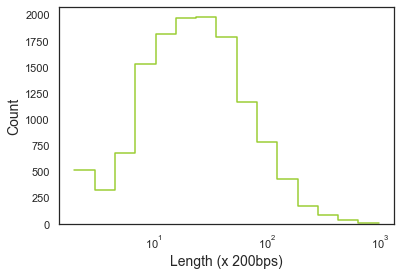

In [416]:
sns.histplot(e050_comp_gene_css_all_len,log_scale=True, element="step", fill=False, color="yellowgreen", bins=15)
print("Total count= {}".format(len(e050_comp_gene_css_all_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

In [69]:
path="../database/bed/gene_expression/"

In [200]:
g_hexp=pd.read_csv(path+"gene_highlyexpressed.refFlat", sep="\t", index_col=False, header=0)
# g_hexp.columns[0]="gene_id"
# g_hexp.index = g_hexp.iloc[:,0]
# g_hexp.index.rename("gene_id")

g_hexp=g_hexp.iloc[:,1:]
g_hexp.rename(columns={"name":"gene_id"}, inplace=True)
g_hexp.rename(columns={"#geneName":"geneName"}, inplace=True)
# g_exp.index = g_exp.iloc[:,0]

g_hexp.head()

,geneName,gene_id,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,gene type,transcript type,reference transcript name,reference transcript id
0,CD99,ENSG00000002586,chrX,+,2609219,2659350,2609401,2658845,10,"[2609219, 2632462, 2635645, 2637701, 2638396, ...","[2609468, 2632495, 2635693, 2637746, 2638465, ...",protein_coding,protein_coding,CD99-001,ENST00000381192
1,LASP1,ENSG00000002834,chr17,+,37026111,37078023,37026442,37075031,7,"[37026111, 37034338, 37046672, 37054664, 37070...","[37026511, 37034433, 37046757, 37054772, 37070...",protein_coding,protein_coding,LASP1-001,ENST00000318008
2,M6PR,ENSG00000003056,chr12,-,9092960,9102551,9094413,9099000,7,"[9092960, 9095011, 9096000, 9096396, 9098013, ...","[9094536, 9095138, 9096131, 9096506, 9098180, ...",protein_coding,protein_coding,M6PR-001,ENST00000000412
3,ARF5,ENSG00000004059,chr7,+,127228398,127231759,127228552,127231353,6,"[127228398, 127229136, 127229538, 127230119, 1...","[127228619, 127229217, 127229648, 127230191, 1...",protein_coding,protein_coding,ARF5-001,ENST00000000233
4,FKBP4,ENSG00000004478,chr12,+,2904118,2913124,2904305,2912424,10,"[2904118, 2906303, 2906894, 2907871, 2908253, ...","[2904410, 2906448, 2907037, 2907992, 2908410, ...",protein_coding,protein_coding,FKBP4-001,ENST00000001008


In [258]:
# function for preprocess the whole gene data and produce chromosome-wise gene lists
# each element is dataframe

def Gexp_Gene2GLChr(exp_gene_file='../database/bed/gene_expression/gene_highlyexpressed.refFlat'):
    print("Extracting the gene file ...")
    g_fn=exp_gene_file
    g_df_raw=pd.read_csv(g_fn, sep='\t', index_col=False, header=0)
    g_df=g_df_raw
    g_df=g_df.iloc[:,1:]
    g_df.rename(columns={"name":"gene_id"}, inplace=True)
    g_df.rename(columns={"#geneName":"geneName"}, inplace=True)
    g_df.rename(columns={"txStart":"TxStart"}, inplace=True) # to make it coherent to my previous codes
    g_df.rename(columns={"txEnd":"TxEnd"}, inplace=True)
#     g_df=g_df_raw.rename(columns={0:"geneName",1:"gene_id",2:"chrom",3:"strand",4:"txStart",5:"txEnd",
#                                       6:"cdsStart",7:"cdsEnd",8:"exonCount",9:"exonStart",10:"exonEnds",
#                                       11:"gene type",12:"transcript type",13:"reference transcript name",
#                                       14:"reference transcription id"})
    ## string to the list of "int", for exon start/end ##
    g_df_temp=g_df # copy for processing
    exon_start_int_lst=[]
    for i, str_lst in enumerate(g_df_temp["exonStarts"]):
        int_lst=[int(elm) for elm in str_lst.replace("[","").replace("]","").split(",")]
        assert g_df_temp["exonCount"][i]==len(int_lst) # make sure the no. element in exon start = count
        exon_start_int_lst.append(int_lst)    
    g_df_temp["exonStarts"]=exon_start_int_lst

    exon_end_int_lst=[]
    for i, str_lst in enumerate(g_df_temp["exonEnds"]):
        int_lst=[int(elm) for elm in str_lst.replace("[","").replace("]","").split(",")]
        assert g_df_temp["exonCount"][i]==len(int_lst) # make sure the no. element in exon start = count
        exon_end_int_lst.append(int_lst)    
    g_df_temp["exonEnds"]=exon_end_int_lst    
    g_df=g_df_temp # and make it back the original name
        
    g_df=g_df[["geneName","gene_id","chrom","TxStart","TxEnd"]] # extract these only
    
    # Remove other than regular chromosomes
    chr_lst=['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10',
             'chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19',
             'chr20','chr21','chr22','chrX','chrY']
    g_df=g_df.loc[g_df["chrom"].isin(chr_lst)]
    
    # Create a list of chromosome-wise dataframe 
    g_df_chr_lst=[]
    for num in range(len(chr_lst)):
        chr_num=chr_lst[num]
        g_chr_df='g_'+chr_num  # name it as "g_"
        locals()[g_chr_df]=g_df[g_df["chrom"]==chr_num]
        g_chr_df=locals()[g_chr_df]
        g_chr_df=g_chr_df.sort_values("TxStart")
        g_df_chr_lst.append(g_chr_df)
        
    # Remove the overlapped area (using removeOverlapDF function in css_utility.py)
    g_df_chr_collapsed_lst=[]
    for g_df_chr in g_df_chr_lst:
        g_df_chr_collapsed=removeOverlapDF(g_df_chr)
        assert len(g_df_chr)>=len(g_df_chr_collapsed)
        g_df_chr_collapsed_lst.append(g_df_chr_collapsed)
    print("Done!")
    
    return g_df_chr_collapsed_lst  # list of dataframe

In [259]:
# highly expressed case
g_df_chr_collapsed_lst=Gexp_Gene2GLChr(exp_gene_file='../database/bed/gene_expression/gene_highlyexpressed.refFlat')

Extracting the gene file ...
Done!


In [376]:
# just expressed case
gexp_df_chr_collapsed_lst=Gexp_Gene2GLChr(exp_gene_file='../database/bed/gene_expression/gene_expressed.refFlat')

Extracting the gene file ...
Done!


In [381]:
# just expressed case - convert to css 
css_exp_gene_lst_all=comp_expGene2css("../database/bed/gene_expression/gene_expressed.refFlat",df_e050)
css_exp_unit_lst_all=Convert2unitCSS_main(css_exp_gene_lst_all, unit=200)

Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...



Done!
Converting css from the raw length into unit-length ... 



Done!


In [382]:
g_exp_css_all=flatLst(css_exp_unit_lst_all)

In [383]:
len(g_exp_css_all)

13469

In [384]:
g_exp_css_all_len=[len(elm) for elm in g_exp_css_all]

Total count= 13469


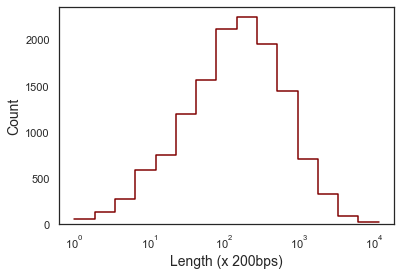

In [389]:
sns.histplot(g_exp_css_all_len,log_scale=True, element="step", fill=False, color="maroon", bins=15)
print("Total count= {}".format(len(g_exp_css_all_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

### So now we have bed files for highly expressed.. then we need CSS for E050 

In [260]:
df_e050=bed2df_expanded("../database/bed/unzipped/E050_15_coreMarks_stateno.bed")
df_e050.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,13200,15,2600,13,O,OOOOOOOOOOOOO
3,chr1,13200,13400,7,200,1,G,G
4,chr1,13400,28400,5,15000,75,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...


In [395]:
df_e050.tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
485249,chrY,58972000,58997400,8,25400,127,H,HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...
485250,chrY,58997400,59001600,9,4200,21,I,IIIIIIIIIIIIIIIIIIIII
485251,chrY,59001600,59002200,8,600,3,H,HHH
485252,chrY,59002200,59033400,9,31200,156,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
485253,chrY,59033400,59373400,15,340000,1700,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [394]:
len(df_e050)

485254

In [262]:
all_unit_css=df2unitcss(df_e050)

In [265]:
len(all_unit_css[0]) # unit length

1246253

In [266]:
css_lst_chr=df2longcss(df_e050)

In [268]:
len(css_lst_chr[0]) # original 

249250600

In [289]:
def comp_expGene2css(exp_gene_file,df):   # df indicates css, created by bed2df_expanded
    """
    modified from `compGene2css`
    Input: Reference gene file, df (CSS)
    Output: list of chromosome-wise list that contains the css at genic area only.
    """
    g_lst_chr=Gexp_Gene2GLChr(exp_gene_file)
#     g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(g_lst_chr)
    
    print("Matching to the chromatin state sequence data ...")
    css_gene_lst_all=[]
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
        css_gene_lst_chr=[]
        for j in range(len(gene_df)):
            g_start=gene_df["TxStart"].iloc[j]-1  # python counts form 0
            g_end=gene_df["TxEnd"].iloc[j]+1      # python excludes the end
            
            css_gene=css[g_start:g_end]           # cut the gene area only
            css_gene_lst_chr.append(css_gene)     # store in the list
          
        css_gene_lst_all.append(css_gene_lst_chr)  # list of list
    
    assert len(css_gene_lst_all)==total_chr
    
    # remove chromosome if it is empty (e.g. chrY for female)
    css_gene_lst_all=[elm for elm in css_gene_lst_all if elm!=[]] 
            
    print("Done!")
    return css_gene_lst_all ## this is the original length! reduce it at Convert2unitCSS_main(css_lst_all, unit=200)!

In [290]:
css_gene_lst_all=comp_expGene2css("../database/bed/gene_expression/gene_highlyexpressed.refFlat",df_e050)

Extracting the gene file ...
Done!
Matching to the chromatin state sequence data ...



Done!


In [291]:
css_unit_lst_all=Convert2unitCSS_main(css_gene_lst_all, unit=200)

Converting css from the raw length into unit-length ... 



Done!


In [296]:
len(css_unit_lst_all[0])

121

In [293]:
g_hexp_css_all=flatLst(css_unit_lst_all)

In [380]:
len(g_hexp_css_all)

1051

In [298]:
g_hexp_css_all[-1]

'AABBBGEEEEEEEEEEEEEEEEEEEEEEEEEEEEGGGGGGGGGGGGGGGGEEEEEEEEEEEEEEEEEEEEEDDDEEEEEEEEEEDDDDDDDDDDDDDDDEEEEEEEEEEEEEEEEEEEEEEEEEDDDDDEEEEEEDDDDDDDDDDDDDHHHHHHHEEEEEEEEEEEHHHHHHHEEEEEEEEEDDDDDDDDDDDDDDDDDDDDDDDDDEEEEEEEEEEEDDDDDDDDDDDDDHHHHHHHHHHHHHHHII'

In [299]:
g_hexp_css_len=[len(elm) for elm in g_hexp_css_all]

In [333]:
len(g_hexp_css_len)

1051

Total count= 1051


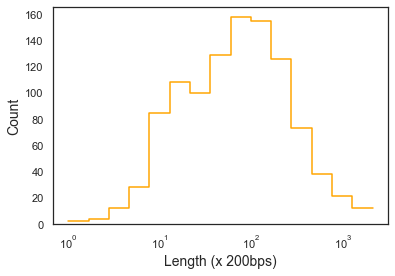

In [373]:
sns.set(rc={"font.size":15, "font.family":"serif"})
sns.set_style("white")
print("Total count= {}".format(len(g_hexp_css_len)))
p=sns.histplot(g_hexp_css_len, log_scale=True, element="step", fill=False, color="orange", bins=15)
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()
# p.set_xticks(p.get_xticks())
# p.set_xticklabels(p.get_xticks(), fontfamily="serif", fontsize=12)

#### Is this length normal..? looks like too short. Let me compare it with complexity case

In [361]:
with open("../database/temp_files/complexity/thres_mean/comp","rb") as f:
    comp_lst=pickle.load(f)

In [364]:
len(comp_lst)

37

In [365]:
comp_css_len=[len(elm) for elm in comp_lst]

Total count= 13484


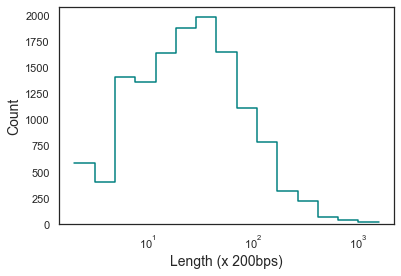

In [375]:
sns.histplot(comp_css_len,log_scale=True,element="step", fill=False, color="teal", bins=15)
print("Total count= {}".format(len(comp_css_len)))
plt.xlabel("Length (x 200bps)", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.show()

#### Convert string to int: exonStarts and exonEnds

In [124]:
exon_start_test=[int(elm) for elm in g_hexp["exonStarts"][0].replace("[","").replace("]","").split(",")]

In [125]:
exon_end_test=[int(elm) for elm in g_hexp["exonEnds"][0].replace("[","").replace("]","").split(",")]

#### Exon is short

In [128]:
np.array(exon_end_test)-np.array(exon_start_test)

array([249,  33,  48,  45,  69,  48,  51, 114,  57, 531])

#### Tx is long

33205.17153284672


<AxesSubplot:ylabel='Count'>

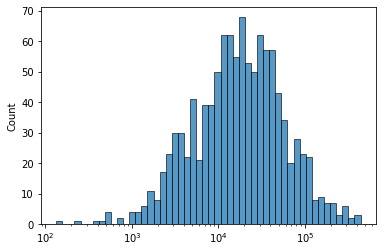

In [136]:
print(np.mean(g_hexp["txEnd"]-g_hexp["txStart"]))
sns.histplot(g_hexp["txEnd"]-g_hexp["txStart"], bins=50, log_scale=True)

In [90]:
g_hexp.sort_values("chrom", inplace=True)
g_hexp.head(20)

,geneName,gene_id,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,gene type,transcript type,reference transcript name,reference transcript id
674,TCTEX1D1,ENSG00000152760,chr1,+,67218142,67244470,67220341,67243137,5,"[67218142, 67220338, 67236069, 67241961, 67242...","[67218267, 67220460, 67236161, 67242086, 67244...",protein_coding,protein_coding,TCTEX1D1-001,ENST00000282670
5,KDM1A,ENSG00000004487,chr1,+,23345940,23410182,23346089,23409857,19,"[23345940, 23356961, 23376879, 23380253, 23381...","[23346440, 23357127, 23377013, 23380332, 23381...",protein_coding,protein_coding,KDM1A-001,ENST00000356634
1092,DCAF8,ENSG00000258465,chr1,-,160187253,160254920,160187381,160251981,18,"[160187253, 160188113, 160188638, 160192440, 1...","[160187498, 160188230, 160188758, 160192571, 1...",protein_coding,protein_coding,DCAF8-001,ENST00000556710
798,IRF2BP2,ENSG00000168264,chr1,-,234740014,234745271,234742882,234745240,2,"[234740014, 234744240]","[234743598, 234745271]",protein_coding,protein_coding,IRF2BP2-001,ENST00000366610
980,CDC42SE1,ENSG00000197622,chr1,-,151023446,151042801,151026722,151028206,8,"[151023446, 151026706, 151027491, 151028152, 1...","[151025803, 151026797, 151027602, 151028469, 1...",protein_coding,protein_coding,CDC42SE1-001,ENST00000439374
855,UQCRH,ENSG00000173660,chr1,+,46769302,46782448,46769438,46782256,4,"[46769302, 46774772, 46775826, 46782223]","[46769492, 46774799, 46775988, 46782448]",protein_coding,protein_coding,UQCRH-001,ENST00000311672
493,ZRANB2,ENSG00000132485,chr1,-,71528973,71546980,71530756,71546678,10,"[71528973, 71532458, 71534958, 71536509, 71537...","[71530820, 71532617, 71535045, 71536679, 71537...",protein_coding,protein_coding,ZRANB2-001,ENST00000370920
857,TOMM20,ENSG00000173726,chr1,-,235272650,235292251,235275378,235292030,5,"[235272650, 235277082, 235283132, 235285640, 2...","[235275423, 235277225, 235283214, 235285687, 2...",protein_coding,protein_coding,TOMM20-001,ENST00000366607
982,S100A10,ENSG00000197747,chr1,-,151955390,151966866,151955638,151958706,3,"[151955390, 151958574, 151966227]","[151955800, 151958727, 151966866]",protein_coding,protein_coding,S100A10-001,ENST00000368811
16,CSDE1,ENSG00000009307,chr1,-,115259533,115300604,115260789,115282511,19,"[115259533, 115261233, 115262199, 115263159, 1...","[115260837, 115261366, 115262363, 115263338, 1...",protein_coding,protein_coding,CSDE1-001,ENST00000339438


In [94]:
g_hexp["chrom"].unique()

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chrX'], dtype=object)

In [13]:
epi57_raw=pd.read_csv(path+"57epigenomes.RPKM.pc.tsv", sep="\t",index_col=False, header=0)

In [15]:
epi57_raw.head()

,gene_id,E000,E003,E004,E005,E006,E007,E011,E012,E013,...,E114,E116,E117,E118,E119,E120,E122,E123,E127,E128
0,ENSG00000000003,23.265,43.985,37.413,29.459,21.864,55.649,52.940,71.629,61.292,...,37.989,0.038,42.639,49.983,11.554,11.847,43.723,0.267,13.758,15.818
1,ENSG00000000005,0.872,1.642,6.498,0.000,0.157,0.003,0.115,0.087,0.055,...,0.000,0.000,0.000,0.000,0.000,0.018,0.000,0.006,0.000,0.000
2,ENSG00000000419,55.208,35.259,58.308,48.208,37.477,45.923,44.959,40.438,41.970,...,52.215,79.197,107.098,62.811,42.386,54.869,16.652,73.719,56.578,56.371
3,ENSG00000000457,3.237,2.596,2.345,8.775,2.723,3.700,3.912,5.011,4.158,...,4.829,11.082,8.814,2.646,2.483,2.527,2.549,7.651,4.967,3.714
4,ENSG00000000460,7.299,6.649,7.838,7.324,0.830,5.354,5.940,5.704,6.213,...,8.001,13.743,25.369,3.373,4.646,2.179,4.099,22.103,3.290,2.491


In [14]:
epi57=epi57_raw

In [6]:
epi57.head()

,gene_id,E000,E003,E004,E005,E006,E007,E011,E012,E013,...,E114,E116,E117,E118,E119,E120,E122,E123,E127,E128
0,ENSG00000000003,23.265,43.985,37.413,29.459,21.864,55.649,52.940,71.629,61.292,...,37.989,0.038,42.639,49.983,11.554,11.847,43.723,0.267,13.758,15.818
1,ENSG00000000005,0.872,1.642,6.498,0.000,0.157,0.003,0.115,0.087,0.055,...,0.000,0.000,0.000,0.000,0.000,0.018,0.000,0.006,0.000,0.000
2,ENSG00000000419,55.208,35.259,58.308,48.208,37.477,45.923,44.959,40.438,41.970,...,52.215,79.197,107.098,62.811,42.386,54.869,16.652,73.719,56.578,56.371
3,ENSG00000000457,3.237,2.596,2.345,8.775,2.723,3.700,3.912,5.011,4.158,...,4.829,11.082,8.814,2.646,2.483,2.527,2.549,7.651,4.967,3.714
4,ENSG00000000460,7.299,6.649,7.838,7.324,0.830,5.354,5.940,5.704,6.213,...,8.001,13.743,25.369,3.373,4.646,2.179,4.099,22.103,3.290,2.491


In [8]:
epi57.index = epi57.iloc[:,0]

In [10]:
epi57.head()

,gene_id,E000,E003,E004,E005,E006,E007,E011,E012,E013,...,E114,E116,E117,E118,E119,E120,E122,E123,E127,E128
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,ENSG00000000003,23.265,43.985,37.413,29.459,21.864,55.649,52.940,71.629,61.292,...,37.989,0.038,42.639,49.983,11.554,11.847,43.723,0.267,13.758,15.818
ENSG00000000005,ENSG00000000005,0.872,1.642,6.498,0.000,0.157,0.003,0.115,0.087,0.055,...,0.000,0.000,0.000,0.000,0.000,0.018,0.000,0.006,0.000,0.000
ENSG00000000419,ENSG00000000419,55.208,35.259,58.308,48.208,37.477,45.923,44.959,40.438,41.970,...,52.215,79.197,107.098,62.811,42.386,54.869,16.652,73.719,56.578,56.371
ENSG00000000457,ENSG00000000457,3.237,2.596,2.345,8.775,2.723,3.700,3.912,5.011,4.158,...,4.829,11.082,8.814,2.646,2.483,2.527,2.549,7.651,4.967,3.714
ENSG00000000460,ENSG00000000460,7.299,6.649,7.838,7.324,0.830,5.354,5.940,5.704,6.213,...,8.001,13.743,25.369,3.373,4.646,2.179,4.099,22.103,3.290,2.491


In [11]:
epi57=epi57.iloc[:,1:]

In [12]:
epi57.head()

,E000,E003,E004,E005,E006,E007,E011,E012,E013,E016,...,E114,E116,E117,E118,E119,E120,E122,E123,E127,E128
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,23.265,43.985,37.413,29.459,21.864,55.649,52.940,71.629,61.292,44.280,...,37.989,0.038,42.639,49.983,11.554,11.847,43.723,0.267,13.758,15.818
ENSG00000000005,0.872,1.642,6.498,0.000,0.157,0.003,0.115,0.087,0.055,1.577,...,0.000,0.000,0.000,0.000,0.000,0.018,0.000,0.006,0.000,0.000
ENSG00000000419,55.208,35.259,58.308,48.208,37.477,45.923,44.959,40.438,41.970,51.515,...,52.215,79.197,107.098,62.811,42.386,54.869,16.652,73.719,56.578,56.371
ENSG00000000457,3.237,2.596,2.345,8.775,2.723,3.700,3.912,5.011,4.158,3.292,...,4.829,11.082,8.814,2.646,2.483,2.527,2.549,7.651,4.967,3.714
ENSG00000000460,7.299,6.649,7.838,7.324,0.830,5.354,5.940,5.704,6.213,7.551,...,8.001,13.743,25.369,3.373,4.646,2.179,4.099,22.103,3.290,2.491


In [18]:
len(epi57)

19795

In [17]:
epi57.describe()

,E000,E003,E004,E005,E006,E007,E011,E012,E013,E016,...,E114,E116,E117,E118,E119,E120,E122,E123,E127,E128
count,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.00000,19795.000000,19795.000000,19795.000000,...,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000,19795.000000
mean,15.616650,15.669690,16.786629,16.176443,16.627451,15.957653,14.25646,13.512338,14.372464,15.280072,...,15.369580,15.892908,14.933831,19.967192,20.046715,16.127057,18.468016,17.351987,19.204572,15.389853
std,59.060454,54.568895,72.916420,89.982958,96.150932,64.905445,49.29719,40.523499,51.430895,50.108760,...,70.770097,77.359634,49.595660,182.542526,165.263021,86.224347,97.655144,111.013555,173.338817,76.854728
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.357500,0.118000,0.086000,0.064000,0.013000,0.064000,0.13900,0.110000,0.135000,0.139000,...,0.032000,0.013000,0.005000,0.012000,0.014000,0.023000,0.012000,0.007000,0.019000,0.014000
50%,4.682000,3.329000,2.653000,2.763000,2.360000,3.573000,4.14500,3.895000,3.729000,3.514000,...,2.602000,1.746000,1.826000,2.408000,2.395000,2.248000,2.198000,1.606000,2.476000,2.147000
75%,15.003500,13.404000,13.385000,12.443500,11.961000,14.279500,14.20450,14.176000,13.311500,13.955000,...,12.969500,13.590500,13.476500,12.422000,12.181500,11.598000,12.166000,13.679500,12.305500,11.519500
max,3445.470000,2211.915000,4517.905000,8590.590000,9123.360000,4063.105000,2688.12000,1574.320000,2935.310000,1894.330000,...,4234.410000,5694.820000,1947.970000,16876.500000,13407.500000,4733.430000,5324.800000,11266.800000,16325.100000,4003.370000


In [47]:
epi57["gene_id"]

0        ENSG00000000003
1        ENSG00000000005
2        ENSG00000000419
3        ENSG00000000457
4        ENSG00000000460
              ...       
19790    ENSG00000259718
19791    ENSG00000259741
19792    ENSG00000259752
19793    ENSG00000259765
19794    ENSG00000259766
Name: gene_id, Length: 19795, dtype: object